# FIT5196 Assessment 3
#### Student Name: Isobel Rowe
#### Student ID: 30042585

Date: 11/06/2019

Version: 2.0

Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

Libraries used:

* pandas (for dataframes)
* numpy (for additional functionality support for Pandas/MatPlotLib)
* math (for various mathematical function)
* shapefile (for readinf the shapefile)
* shapely.geometry (for finding suburb)
* sklearn.preprocessing (for normalisation/transformation)
* matplotlib (for plotting)
* seaborn (for plotting)




## 1. Introduction

This Assignment 3 in FIT5196, which involves using data integration and data reshaping in order to form a cleaned data file. The assessment is split into two tasks:

1. Data Integration: requires the integration of various data files into a single, wrangled file. This is done by computing the values of:
     + Suburb
     + train_station_id
     + distance_to_train_station
     + travel_min_to_CBD
     + over_priced?
     + crime_A_average
     + crime_B_average
     + crime_C_average
     

2. Data Reshaping: study the effects of various normalisation and transformation techniques on the wrangled dataset on various attributes in order to observe and explain their effects in terms of building a linear model on the Price attribute.


More details for each task will be given in the following sections.

## 2. Import libraries

In [1]:
# Dataframe 
import pandas as pd

# Additonal functionality for dataframe
import numpy as np

# Haversine
from math import radians, cos, sin, asin, sqrt

# Shapefile 
import shapefile
from shapely.geometry import Point, shape

# Normalisation/transformation
from sklearn import preprocessing
from sklearn.preprocessing import FunctionTransformer
#import math

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set(font_scale = 1.5)

# Error handling
import warnings
warnings.filterwarnings('ignore')


## 3. Task 1: Data Integration

This task is split into:

* 3.1: Read in file / intital processing 
* 3.2: suburb
* 3.3: train_station_id and distance_to_train_station
* 3.4: travel_min_to_cbd
* 3.5: over_priced?
* 3.6: crime_A/B/C_average
* 3.7: Finishing up




### 3.1 Read in file

I start by reading in the data file with read_csv. I also conduct a small amount of inital processing to check for both missing values and duplicate records.

In [2]:
# Read in file
df = pd.read_csv('30042585.csv')

# Check the shape
print('Shape: ', df.shape)

# Check NAN values
print('Are there NAN values?', df.isnull().values.any())

# Immediately check for duplicate rows
duplicates = df.drop(['ID'], axis=1)
print('Number of duplicated rows: ', sum(duplicates.duplicated()))


Shape:  (720, 12)
Are there NAN values? False
Number of duplicated rows:  41


This found that there are no missing values, but that there are 41 duplicate rows, so I will drop the duplicate rows by keeping only the first record, and then check the shape of the dataframe.

In [3]:
# dropping duplicte values, keeping first
df.drop_duplicates(keep = 'first', inplace = True) 

# Check the shape
print('Shape after dropping duplicates: ', df.shape)

Shape after dropping duplicates:  (679, 12)


Next, I insert the new columns into their ordered index and add the default values as speicified by the assignment specifications.

In [4]:
# add columns and assign them default values
df.insert(2, 'Suburb', 'not available')
df.insert(13, 'train_station_id', 0)
df.insert(14, 'distance_to_train_station', 0)
df.insert(15, 'travel_min_to_CBD', 0)
df.insert(16, 'over_priced?', -1)
df.insert(17, 'crime_A_average', -1)
df.insert(18, 'crime_B_average', -1)
df.insert(19, 'crime_C_average', -1)

Finally, after the initial preprocessing, I can get into working out the values for columns that need to be integrated.

### 3.2. suburb

First, I work on the suburb values. This attribute is simply the suburb that each property is in. To find this, I read in the main shapefile (.shp - which contains the geometry data) using shapefile.Reader, and print out both the size and the first record just to check everything is in order.



In [5]:
# read all files called 'VIC_LOCALITY_POLYGON_shp'
shapefile = shapefile.Reader("VIC_LOCALITY_POLYGON_shp.shp")

# Print the size of the shapefile
print("Length of the shapefile: ", len(shapefile.records())) # check the size

# Print the first record
print(shapefile.records()[0]) # records: text info
print(shapefile.records()[1])
print(shapefile.records()[3])

Length of the shapefile:  2973
Record #0: ['6670', datetime.date(2011, 8, 31), None, 'VIC2615', datetime.date(2012, 4, 27), None, 'UNDERBOOL', '', '', 'G', None, '2']
Record #1: ['6671', datetime.date(2011, 8, 31), None, 'VIC1986', datetime.date(2012, 4, 27), None, 'NURRAN', '', '', 'G', None, '2']
Record #3: ['6673', datetime.date(2011, 8, 31), None, 'VIC734', datetime.date(2017, 8, 9), None, 'DEPTFORD', '', '', 'G', None, '2']


So, we found that index 6 is where the suburb name is kept.


Next, I make a function to find the suburb for each record in the dataframe. I make use of shapely.polygon to 

In [6]:
def find_suburb(row):
    stopper = 0
    while stopper < len(records):
        # Fetch each suburb
        suburb = shape_records[stopper]
        
        # Convert the type which can be used by shapely
        geo = suburb.shape.__geo_interface__
        shapely_polygon = shape(geo) 
        
        # Fetch Longitude and Lattitude(sic) of each property
        point = Point(row['Longtitude'], row['Lattitude'])

        # Fetch the suburb name from the index 6
        suburb_name = records[stopper][6]
        
        # Check if the point is in the specific suburb of the record
        if point.within(shapely_polygon):
            # If it is, return the suburb name
            return suburb_name
        else:
            # If not, continue to find which suburb the point belongs to
            stopper += 1 


Now, I can define the variables, apply the function, and display the top of the dataframe to check that everything ran smoothly.

In [7]:
# Define the variables to be used in the function.
records = shapefile.records()
shape_records = shapefile.shapeRecords()

# Apply the function to the suburb column
df['Suburb'] = df.apply(find_suburb, axis=1)

# Check the head of the dataframe
display(df.head())

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID459609360,3/37 Highview Dr,DONCASTER,3,u,910000.0,7/11/2016,2.0,2.0,299.0,18.0,-37.79290,145.13380,0,0,0,-1,-1,-1,-1
1,ID913481746,141/95 Rouse St,PORT MELBOURNE,2,u,1250000.0,22/05/2016,2.0,2.0,0.0,16.0,-37.84350,144.94150,0,0,0,-1,-1,-1,-1
2,ID834176626,23 Arthur Av,BRIGHTON,5,h,3000000.0,12/08/2017,3.0,2.0,818.0,57.0,-37.92335,144.99982,0,0,0,-1,-1,-1,-1
4,ID998395922,2/953 High St,RESERVOIR,2,h,555000.0,11/02/2017,1.0,2.0,229.0,49.0,-37.71000,145.00820,0,0,0,-1,-1,-1,-1
5,ID866019840,1/26 Maidstone St,ALTONA,4,t,820000.0,22/07/2017,2.0,2.0,288.0,49.0,-37.87171,144.81273,0,0,0,-1,-1,-1,-1


### 3.3. train_station_id and distance_to_train_station

These attributes are: 

* train_station_id: the closest train station to the property that has a direct (no transfers) trip to the
Southern Cross Railway Station, Monday-friday, 7:30-9:00 AM. Default value: 0
* distance_to_train_station: the direct distance from the closest train station to the property. Default value: 0

In order to find the train station ID and the distance to train station, I had to do quite a lot of processing and sorting of the GTFS datasets.

The closest train station to each property was defined as the train station that has a direct trip to Southern Cross Station on all weekdays (Monday-Friday), from 7 to 9:30. Because of this definition, I basically used each consecutive file to narrow down the search a little bit more.

Note: I used only the first two folders of the GTFS dataset. This is because, just by looking at them, I could tell that the first two are the only ones with trains - the others are either bus routes or tram routes. I double checked this with the links provided in the assignment specs.

#### calendar.txt

First, I use the calendar to find the service_id that have trips Monday-Tuesday.

In [8]:
#Read in calendar
filenames = ['/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/1/google_transit/calendar.txt',
                      '/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/2/google_transit/calendar.txt']

calendar = pd.concat([pd.read_csv(f) for f in filenames])

# Display
display(calendar.head())


,service_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,UR,0,0,0,1,0,0,0,20190509,20190509
1,T6,0,0,0,0,1,0,0,20190510,20190510
2,T2,0,0,0,0,0,1,0,20190511,20190511
3,UJ,0,0,0,0,0,0,1,20190512,20190512
4,UO,1,0,0,0,0,0,0,20190513,20190513


I filtered out trips that aren't Monday-Friday, and made a list of all the unique service_id using list(set())

In [9]:
#Filter out trips that aren't monday-friday
calendar = calendar[(calendar['monday'] == 1) & (calendar['tuesday'] == 1)
                   & (calendar['wednesday'] == 1)& (calendar['thursday'] == 1)
                   & (calendar['friday'] == 1)]

# Make a list of all the unique service_id that run Monday-Friday
cal_service_id = list(set(calendar['service_id']))

print(cal_service_id)

['T0_3', 'T0_1', 'T0_2', 'T0']


#### trips.txt

I then use the service_id made in the previous section to narrow down the trips file.

In [10]:
#Read in calendar
filenames = ['/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/1/google_transit/trips.txt',
                      '/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/2/google_transit/trips.txt']
trips = pd.concat([pd.read_csv(f) for f in filenames])


print("Length of file before filtering: ", len(trips))

# Ensure it's Monday-Friday
trips = trips.loc[trips['service_id'].isin(cal_service_id)]

print("Length of file after filtering: ", len(trips))

Length of file before filtering:  32356
Length of file after filtering:  3764


The next step is to ensure that the train is heading into the city. From this, I produce a list of all the trip_id that run Monday-Tuesday, and head towards the city. I thought about using the direction_id but that didn't seem to work. So, I used trip_headsign to ensure that either 'Melbourne' or 'City' was in the string. Then, I made a list of all the trip_id that both run from Monday-Tuesday and head towards the city.

In [11]:
# Ensure it's heading into the city
melb = trips[trips['trip_headsign'].str.match('Melbourne')]
melb_list = list(melb['trip_id'])
city = trips[trips['trip_headsign'].str.match('City')]
city_list = list(city['trip_id'])

# Add the lists together
trip_id = melb_list + city_list
print("Length of file after second filtering: ", len(trip_id))

Length of file after second filtering:  1846


#### stop_times.txt

Using stop_times.txt, I filtered out any records that aren't in the trip_id list made in the previous section. 

In [12]:
#Read in stop times
filenames = ['/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/1/google_transit/stop_times.txt',
                      '/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/2/google_transit/stop_times.txt']
stop_times = pd.concat([pd.read_csv(f) for f in filenames])

# Print the length
print("Length before filtering: ", len(stop_times))

# Filter out any trip id that doesn't appear in trip_id list
stop_times = stop_times.loc[stop_times['trip_id'].isin(trip_id)]
print("Length after filtering trip_id: ",len(stop_times))


Length before filtering:  541977
Length after filtering trip_id:  29264


Next, I ensure that the departure time is between 7:30 AM and 9:00 AM.

In [13]:
#Filter out departure times outside of 7:30-9:30
stop_times = stop_times[(stop_times['departure_time'] > '07:30:00') & (stop_times['departure_time'] < '09:00:00')]

# Check the length
print("Length after filtering on departure time: ", len(stop_times))
#stop_times = stop_times.loc[stop_times['trip_id'].isin(trip_id)]


Length after filtering on departure time:  4084


Next, I made a list of all the trip id that make a stop at Southern Cross Station.

In [14]:
# Southern Cross Station
scs_1 = stop_times.loc[stop_times['stop_id'] == 22180]
scs_1_list = list(scs_1['trip_id'])

scs_2 = stop_times.loc[stop_times['stop_id'] == 20043]
scs_2_list = list(scs_2['trip_id'])

# Concatenate the lists together
stops_to_scs = scs_1_list + scs_2_list

Finally, I use this list of trip_id that stop at Southern Cross Station to filter the stop_times further, and end up with a list of unique stop_id that:

- head to Southern Cross Station
- depart between 7:30-9:00
- run Monday-Friday

In [15]:
# now we need to find the stop id that they correspond to 
stop_times = stop_times.loc[stop_times['trip_id'].isin(stops_to_scs)]

stop_id = list(set(stop_times['stop_id']))

print('Number of valid stops: ', len(stop_id))

Number of valid stops:  237


#### stops.txt

Finally, I have a list of all the stations that we are interested in! So now I can simply use this list to filter the stops file 

In [16]:
# Create the list of file names: 
filenames = ['/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/1/google_transit/stops.txt', 
             '/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/gtfs/2/google_transit/stops.txt']

stops = pd.concat([pd.read_csv(f) for f in filenames])

# Check length before filtering
print('Number of stops before filtering: ', len(stops))

# Filter out stop_id not in stop_id list from previous section
stops = stops.loc[stops['stop_id'].isin(stop_id)]

# Check length after filtering
print('Number of stops after filtering: ', len(stops))

Number of stops before filtering:  331
Number of stops after filtering:  237


#### Calculating 
OK, the stops have been wrangled to include only those that have a direct train to southern cross monday-friday 7:30-9 am. Now we can find the closest train station for each property. I create two functions:

* haversine: formula for computing distance between two points to be used in the next function.
* station_and_distance: finds closest station and distance to it using haversine


In [17]:
def haversine(lon1, lat1, lon2, lat2):

    # Convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # Formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    
    # Radius of earth as specified in assignment specs
    r = 6378 
    
    # Return the distance
    return c * r

In [18]:
# Define function
def station_and_distance(df, stops):
    
    # Create empty lists for distance and station
    distance = []
    station = []
    
    # Coordinates of house
    for property_index, property_row in df.iterrows():
        
        # Empty list for minimum distance
        distance_list = []
        
        # Coordinates gps of train station
        for station_index, station_row in stops.iterrows():
            # Find distance with haversine function
            distance_list.append(haversine(station_row['stop_lon'], station_row['stop_lat'], property_row['Longtitude'], property_row['Lattitude']))
            
        # Add min distance into distance
        distance.append(min(distance_list))
        
        # Get the index of the min distance
        closest_station = distance_list.index(min(distance_list))
        
        # Add index into station
        station.append(closest_station)
        
    return distance, station

Now, we can call on the function and fill in the dataframe with the computed values.

In [19]:
# Call the function and store output
minimum_distance, closest_list = station_and_distance(df, stops)

# Use the index list to find train station ID
closest_train_station = []
for each in closest_list:
    closest_train_station.append(stops.iloc[each]['stop_id'])
    
# Fill in the dataframe
df['train_station_id'] = closest_train_station
df['distance_to_train_station'] = minimum_distance

# Converting KM to metres and rounding to 2 as per forum post
df['distance_to_train_station'] = (df['distance_to_train_station']*1000).round(2)

### 3.4 travel_min_to_CBD

This attribute is the average travel time (in minutes) from the closest train station (as found in the previous section) and Southern Cross Station. The default value is 0.

I also need to remember that if the closest train station to the property is Southern Cross, there should be no average travel time to CBD.

To start, I find the arrival time at Southern Cross station for each trip_id, and merge it into the stop_times dataframe on trip_id.


In [20]:
# Find arrival time at scs for each trip_id
scs = [22180, 20043]
arrival_at_scs = stop_times.loc[stop_times['stop_id'].isin(scs)]

# Create new column
arrival_at_scs['arrival at scs'] = arrival_at_scs['arrival_time']

# Merge on trip_id
stop_times = pd.merge(stop_times, arrival_at_scs[['trip_id', 'arrival at scs']], on= 'trip_id', how='left')

# Take a look
stop_times.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,arrival at scs
0,1094.T0.1-V12-G-mjp-1.1.H,07:31:00,07:31:00,20361,2,NaN,0,0,13417.188090,08:39:00
1,1094.T0.1-V12-G-mjp-1.1.H,07:37:00,07:37:00,20325,3,NaN,0,0,22263.268829,08:39:00
2,1094.T0.1-V12-G-mjp-1.1.H,07:41:00,07:41:00,20315,4,NaN,0,0,27817.107724,08:39:00
3,1094.T0.1-V12-G-mjp-1.1.H,07:46:00,07:46:00,20337,5,NaN,0,0,35154.789037,08:39:00
4,1094.T0.1-V12-G-mjp-1.1.H,07:51:00,07:51:00,20303,6,NaN,0,0,41651.092233,08:39:00


Next, I convert the times to a datetime object, and calculate the difference between arrival and departure.


I realised at this point that the city loop (ie. Parliament, Melbourne Central Station) trains are difficult as values may be in the negatives as the train may go from city loop station --> Southern Cross.

This is because when filtering the direction of the train to include only those who are headed to the CBD, it didn't take into account stations that are already in the city.

This was easy to fix, though, as I decided the best way to deal with this was to drop the values that are negative from the dataframe.

In [21]:
# Making a datetime object
stop_times['arrival at scs'] = pd.to_datetime(stop_times['arrival at scs'], format = '%H:%M:%S')
stop_times['departure_time'] = pd.to_datetime(stop_times['departure_time'], format = '%H:%M:%S')
    
# Calculating the difference
stop_times['travel time'] = stop_times['arrival at scs'] - stop_times['departure_time']


# Drop negative values
stop_times.drop(stop_times[stop_times['travel time'] < pd.Timedelta(0)].index, inplace=True)


# Converting into seconds and then minutes
stop_times['travel time'] = stop_times['travel time'].dt.total_seconds()/60

Now, I can use a groupby coupled with .describe() on stop_id to find the mean (average) of the travel time.

In [22]:
# Create .groupby().describe()
groupby_stop_id = stop_times.groupby('stop_id').describe()

# Isolate travel_time attribute
travel_times = groupby_stop_id['travel time']

# Take a look at the dataframe
travel_times.head()

,count,mean,std,min,25%,50%,75%,max
stop_id,,,,,,,,
15351,3.0,46.666667,5.507571,43.0,43.5,44.0,48.5,53.0
15353,3.0,42.666667,5.507571,39.0,39.5,40.0,44.5,49.0
17204,4.0,59.000000,0.000000,59.0,59.0,59.0,59.0,59.0
19841,70.0,3.057143,2.776118,2.0,2.0,2.0,2.0,11.0
19842,68.0,4.558824,1.449471,4.0,4.0,4.0,4.0,9.0


Next, I can merge with the dataframe.

In [23]:
# Reset the index
travel_times = travel_times.reset_index()

# Remove unwanted columns
travel_times.drop(['count', 'std', 'min', '25%', '50%', '75%', 'max'], axis = 1, inplace = True)

# rename 
travel_times['train_station_id'] = travel_times['stop_id']

# Merge
df = pd.merge(df, travel_times[['train_station_id', 'mean']], on = 'train_station_id', how = 'left')

# Check the merge was successful
df.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,...,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,mean
0,ID459609360,3/37 Highview Dr,DONCASTER,3,u,910000.0,7/11/2016,2.0,2.0,299.0,...,-37.79290,145.13380,20042,3125.54,0,-1,-1,-1,-1,25.4
1,ID913481746,141/95 Rouse St,PORT MELBOURNE,2,u,1250000.0,22/05/2016,2.0,2.0,0.0,...,-37.84350,144.94150,20043,2964.33,0,-1,-1,-1,-1,0.0
2,ID834176626,23 Arthur Av,BRIGHTON,5,h,3000000.0,12/08/2017,3.0,2.0,818.0,...,-37.92335,144.99982,19951,965.39,0,-1,-1,-1,-1,26.0
3,ID998395922,2/953 High St,RESERVOIR,2,h,555000.0,11/02/2017,1.0,2.0,229.0,...,-37.71000,145.00820,20009,261.19,0,-1,-1,-1,-1,35.0
4,ID866019840,1/26 Maidstone St,ALTONA,4,t,820000.0,22/07/2017,2.0,2.0,288.0,...,-37.87171,144.81273,19925,731.82,0,-1,-1,-1,-1,28.0


Finally, I can update the travel_min_to_CBD attribute in the dataframe with the calculated value. I also make sure to 

In [24]:
# finally, replace travel_min_to_cbd
df['travel_min_to_CBD'] = df['mean'].round(2)

# drop temporary column
df.drop('mean', axis=1, inplace=True)

### 3.5 over_priced?

Next is the over_priced? column. This is a boolean feature used to indicate whether the price of a particular property was higher than the median, with respect to bedrooms, bathrooms, parking_space, and
property_type attributes) in the same suburb on the year of selling. Default value: -1


To start, I create a new dataframe that uses df.groupby() on all the relevant variables and then df.describe() to get the summary statistics, including '50%', which is the median value. I then isolate just the price variable.

In [25]:
# Create a year variable to make it easier to groupby
df['year'] = pd.DatetimeIndex(df['Date']).year

# Groupby on all the relevant variables
overpriced_gb = df.groupby(['Suburb', 'year', 'Rooms', 'Bathroom', 'Car', 'Type']).describe()

# Isolate the price variable
price = overpriced_gb['Price']

price.head()

count       mean  std        min  \
Suburb       year Rooms Bathroom Car Type                                     
ABBOTSFORD   2016 2     1.0      1.0 h       1.0   890000.0  NaN   890000.0   
             2017 3     1.0      1.0 h       1.0  1402500.0  NaN  1402500.0   
ABERFELDIE   2017 1     1.0      1.0 u       1.0   310000.0  NaN   310000.0   
                  4     3.0      2.0 h       1.0  1646000.0  NaN  1646000.0   
AIRPORT WEST 2016 3     2.0      2.0 h       1.0   670000.0  NaN   670000.0   

                                                 25%        50%        75%  \
Suburb       year Rooms Bathroom Car Type                                    
ABBOTSFORD   2016 2     1.0      1.0 h      890000.0   890000.0   890000.0   
             2017 3     1.0      1.0 h     1402500.0  1402500.0  1402500.0   
ABERFELDIE   2017 1     1.0      1.0 u      310000.0   310000.0   310000.0   
                  4     3.0      2.0 h     1646000.0  1646000.0  1646000.0   
AIRPORT WEST 2016 3     2.0      2.0 h      670000.0   670000.0   670000.0   

                                                 max  
Suburb       year Rooms Bathroom Car Type             
ABBOTSFORD   2016 2     1.0      1.0 h      890000.0  
             2017 3     1.0      1.0 h     1402500.0  
ABERFELDIE   2017 1     1.0      1.0 u      310000.0  
                  4     3.0      2.0 h     1646000.0  
AIRPORT WEST 2016 3     2.0      2.0 h      670000.0

Next, I am going to merge this new 'price' dataframe with the original. To do this, I reset the index in order to flatten or remove the double header and remove the unneeded columns. 

In [26]:
# Reset the index
price = price.reset_index()

# Remove unwanted columns
price.drop(['count', 'std', 'mean', 'min', '25%', '75%', 'max'], axis=1, inplace=True)

Next, I can merge this dataframe with the property dataframe.

In [27]:
# Merge
df = pd.merge(df, price,  how='left', left_on=['Suburb', 'year', 'Rooms', 'Bathroom', 'Car', 'Type'], right_on = ['Suburb', 'year', 'Rooms', 'Bathroom', 'Car', 'Type'])

# Check the merge was successful
df.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,...,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,year,50%
0,ID459609360,3/37 Highview Dr,DONCASTER,3,u,910000.0,7/11/2016,2.0,2.0,299.0,...,145.13380,20042,3125.54,25.4,-1,-1,-1,-1,2016,910000.0
1,ID913481746,141/95 Rouse St,PORT MELBOURNE,2,u,1250000.0,22/05/2016,2.0,2.0,0.0,...,144.94150,20043,2964.33,0.0,-1,-1,-1,-1,2016,1250000.0
2,ID834176626,23 Arthur Av,BRIGHTON,5,h,3000000.0,12/08/2017,3.0,2.0,818.0,...,144.99982,19951,965.39,26.0,-1,-1,-1,-1,2017,3125000.0
3,ID998395922,2/953 High St,RESERVOIR,2,h,555000.0,11/02/2017,1.0,2.0,229.0,...,145.00820,20009,261.19,35.0,-1,-1,-1,-1,2017,715000.0
4,ID866019840,1/26 Maidstone St,ALTONA,4,t,820000.0,22/07/2017,2.0,2.0,288.0,...,144.81273,19925,731.82,28.0,-1,-1,-1,-1,2017,820000.0


Finally, I can update the over_priced column using the newly added '50%' column, using np.where. 

In [28]:
# Update over_priced column
df['over_priced?'] = np.where(df['50%'] < df['Price'], 1, 0)

# Revert column back to default value if there price == median, ie there's only one record
#df.loc[(df['Price'] == df['50%']), ['over_priced?']] = -1

# Remove temporary columns
df.drop(['year', '50%'], axis=1, inplace=True)

### 3.6 crime_A/B/C_average

This attribute is the average of a particular crime type for a local government area for the three years prior to the property being sold. The default value is -1.

#### Finding the Local Government Area

The first step for working out the crime averages is finding the local government area that each suburb belongs to. I use the councils dataset to do this.

In [29]:
# Read in the file as a fwf 
councils = pd.read_fwf('/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/councils.txt', header = None)

# Rename column
councils.columns = ['Area']

# Split on : to extract suburb
councils['Area'], councils['suburb'] = councils['Area'].str.split(':', 1).str

# Check
councils.head()

,Area,suburb
0,BANYULE,"['Abbotsford', 'Airport West', 'Albert Park',..."
1,BRIMBANK,"['Altona', 'Altona North', 'Armadale', 'Ascot..."
2,DAREBIN,"['Ashburton', 'Ashwood', 'Avondale Heights', ..."
3,HOBSONS BAY,"['Balwyn', 'Balwyn North', 'Bentleigh', 'Bent..."
4,HUME,"['Box Hill', 'Braybrook', 'Brighton', 'Bright..."


Next, to make this dataframe into something I can work with. Because the 'suburb' column is a single cell with multiple comma seperated values, I decided to explode it into multiple rows. Apparently, there is no straightforward way to clean this in Pandas, but it’s not that difficult either.

The steps are as follows:


In [30]:
# Step 1: We start by creating a new dataframe from the series with Area as the index
new_councils = pd.DataFrame(councils.suburb.str.split(',').tolist(), index = councils.Area).stack()

# Step 2: We now want to get rid of the secondary index
new_councils = new_councils.reset_index([0, 'Area'])

# Step 3: The final step is to set the column names as we want them
new_councils.columns = ['Area', 'suburb']


Clean it up a little bit by removing punction, converting to uppercase and renaming the suburb column to match the property dataframe.

In [31]:
# Remove punctuation
new_councils["suburb"] = new_councils['suburb'].str.replace('[^\w\s]','')

# Make uppercase - easier to match
new_councils["suburb"] = new_councils["suburb"].str.upper()  

# Rename column to match dataframe
new_councils.rename({'suburb': 'Suburb'}, axis=1, inplace=True)

# Take a peek
new_councils.head()

,Area,Suburb
0,BANYULE,ABBOTSFORD
1,BANYULE,AIRPORT WEST
2,BANYULE,ALBERT PARK
3,BANYULE,ALPHINGTON
4,BRIMBANK,ALTONA


Now we can merge the Area value into the properties dataframe. Initially, I found that my merge wasn't working, so I stripped the suburb values just incase there was any trailing/leading whitespaces that I couldn't spot. This worked well.

In [32]:
# Stripping the 'suburb' columns
df['Suburb'] = df['Suburb'].str.strip()
new_councils['Suburb'] = new_councils['Suburb'].str.strip()

# Merging
df = pd.merge(df,new_councils[['Suburb','Area']],on = 'Suburb', how = 'left')

# Checking
df.head()

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,...,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average,Area
0,ID459609360,3/37 Highview Dr,DONCASTER,3,u,910000.0,7/11/2016,2.0,2.0,299.0,...,-37.79290,145.13380,20042,3125.54,25.4,0,-1,-1,-1,MORELAND
1,ID913481746,141/95 Rouse St,PORT MELBOURNE,2,u,1250000.0,22/05/2016,2.0,2.0,0.0,...,-37.84350,144.94150,20043,2964.33,0.0,0,-1,-1,-1,BOROONDARA
2,ID834176626,23 Arthur Av,BRIGHTON,5,h,3000000.0,12/08/2017,3.0,2.0,818.0,...,-37.92335,144.99982,19951,965.39,26.0,0,-1,-1,-1,HUME
3,ID998395922,2/953 High St,RESERVOIR,2,h,555000.0,11/02/2017,1.0,2.0,229.0,...,-37.71000,145.00820,20009,261.19,35.0,0,-1,-1,-1,EAST GIPPSLAND
4,ID866019840,1/26 Maidstone St,ALTONA,4,t,820000.0,22/07/2017,2.0,2.0,288.0,...,-37.87171,144.81273,19925,731.82,28.0,0,-1,-1,-1,BRIMBANK


#### Finding Crime Averages

Now that I have the local government areas, I can move on to find the crime rates. So, I read in the crime excel file and take a peek with head().



In [33]:
# Read in file and remove unwanted header room
crime = pd.read_excel('/Users/isobelrowe/Documents/FIT5196 WRANGLING/ASSIGNMENT 3/crimebylocationdatatable-yearending31march2016.xlsx', 
                    sheet_name="Table 1", header=19)
# Take a peek
crime.head()

,Apr - Mar reference period,Police Region,Police Service Area,Local Government Area,CSA Offence Division,CSA Offence Subdivision,Offence Count,LGA ERP,Victorian ERP
NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A10 Homicide and related offences,4,123600,5632521
NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A20 Assault and related offences,568,123600,5632521
NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A30 Sexual offences,132,123600,5632521
NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A40 Abduction and related offences,12,123600,5632521
NaN,2012,1 North West Metro,BANYULE,BANYULE,A Crimes against the person,A50 Robbery,46,123600,5632521


Now, we can work out the averages. So, for each property, we need crime rates based on:
- Offence type (A, B, and C)
- Year
- Local Government Area

I know that all the properties were sold in either 2016 or 2017, so that year groups we're interested in are 2013-2015, and 2014-2016.

All three crime types are calculated in the same way, so I create a reusable function, where the input is the offence type. I essentially use this function to filter the crime by the relevant attributes, and then find the averages for each.

In [34]:
def find_crime_rates(offence_type):
    
    #global crime
    
    # Filter based on offence
    crime_filter = crime.loc[crime['CSA Offence Division'] == offence_type]

    # Filter based on year
    crime_2016 = crime_filter.loc[crime_filter['Apr - Mar reference period'] == 2016]
    crime_2015 = crime_filter.loc[crime_filter['Apr - Mar reference period'] == 2015]
    crime_2014 = crime_filter.loc[crime_filter['Apr - Mar reference period'] == 2014]
    crime_2013 = crime_filter.loc[crime_filter['Apr - Mar reference period'] == 2013]

    # Filter (with groupby) on local govt area and sum all values
    crime_2016 = crime_2016.groupby('Local Government Area', sort=False)['Offence Count'].sum()
    crime_2015 = crime_2015.groupby('Local Government Area', sort=False)['Offence Count'].sum()
    crime_2014 = crime_2014.groupby('Local Government Area', sort=False)['Offence Count'].sum()
    crime_2013 = crime_2013.groupby('Local Government Area', sort=False)['Offence Count'].sum()

    # Create lists from these sums
    crime_2016 = crime_2016.tolist() 
    crime_2015 = crime_2015.tolist() 
    crime_2014 = crime_2014.tolist() 
    crime_2013 = crime_2013.tolist() 
    
    # Zip lists
    list_14_16 = list(zip(crime_2016, crime_2015, crime_2014))
    list_13_15 = list(zip(crime_2015, crime_2014, crime_2013))

    # Compute average
    result_14_16 = [[sum(tup)/len(tup)] for tup in list_14_16]
    result_13_15= [[sum(tup)/len(tup)] for tup in list_13_15]
    
    # Create dataframe via dictionary
    d = {'Area' : LGA, '14-16' : result_14_16, '13-15' : result_13_15}
    crime_averages = pd.DataFrame(d)

    # Strip area values to ensure a good merge
    crime_averages['Area'] = crime_averages['Area'].str.strip()
    df['Area'] = df['Area'].str.strip()

    # Remove square brackets
    crime_averages['14-16'] = crime_averages['14-16'].str[0]
    crime_averages['13-15'] = crime_averages['13-15'].str[0]
    
    return crime_averages


Now, we can define the variables used in the function, and call on the function to caluculate the averages for each crime.

In [35]:
# Define variables
# Find all Local Govt Areas
LGA = crime["Local Government Area"].unique()

# Extract the year sold
df['year'] = pd.DatetimeIndex(df['Date']).year



### Crime type A ###

# Call on the function
crime_averages_A = find_crime_rates('A Crimes against the person')

# Merge
df = pd.merge(df,crime_averages_A[['14-16','13-15', 'Area']], on = 'Area', how = 'left')

# Convert crime A column to correct values and round down
df.loc[(df['year'] == 2016), ['crime_A_average']] = df['13-15'].round(2)
df.loc[(df['year'] == 2017), ['crime_A_average']] = df['14-16'].round(2)

# Drop the temporary columns so they can be used again 
df.drop(['14-16', '13-15'], axis=1, inplace=True)



### Crime type B ###

# Call on the function
crime_averages_B = find_crime_rates('B Property and deception offences')

# Merge
df = pd.merge(df,crime_averages_B[['14-16','13-15', 'Area']], on = 'Area', how = 'left')

# Change crime a column to correct values
df.loc[(df['year'] == 2016), ['crime_B_average']] = df['13-15'].round(2)
df.loc[(df['year'] == 2017), ['crime_B_average']] = df['14-16'].round(2)

# Drop the temporary columns so they can be used again 
df.drop(['14-16', '13-15'], axis=1, inplace=True)



### Crime type C ###

# Call on the function
crime_averages_C = find_crime_rates('C Drug offences')

# Merge
df = pd.merge(df,crime_averages_C[['14-16','13-15', 'Area']], on = 'Area', how = 'left')

# Change crime a column to correct values
df.loc[(df['year'] == 2016), ['crime_C_average']] = df['13-15'].round(2)
df.loc[(df['year'] == 2017), ['crime_C_average']] = df['14-16'].round(2)

# Drop the temporary columns from the dataframe
df.drop(['14-16', '13-15', 'Area', 'year'], axis=1, inplace=True)


### 3.7 Finishing up

Finally, all that needs to be done is saving the integrated dataframe to a .csv file.

In [36]:
# Take a final look at the dataframe to check that everything is in order
df

,ID,Address,Suburb,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,train_station_id,distance_to_train_station,travel_min_to_CBD,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID459609360,3/37 Highview Dr,DONCASTER,3,u,910000.0,7/11/2016,2.0,2.0,299.0,18.0,-37.79290,145.13380,20042,3125.54,25.40,0,1566.67,8895.33,491.00
1,ID913481746,141/95 Rouse St,PORT MELBOURNE,2,u,1250000.0,22/05/2016,2.0,2.0,0.0,16.0,-37.84350,144.94150,20043,2964.33,0.00,0,659.00,5219.33,338.33
2,ID834176626,23 Arthur Av,BRIGHTON,5,h,3000000.0,12/08/2017,3.0,2.0,818.0,57.0,-37.92335,144.99982,19951,965.39,26.00,0,2897.33,11243.00,942.00
3,ID998395922,2/953 High St,RESERVOIR,2,h,555000.0,11/02/2017,1.0,2.0,229.0,49.0,-37.71000,145.00820,20009,261.19,35.00,0,885.00,1901.00,227.67
4,ID866019840,1/26 Maidstone St,ALTONA,4,t,820000.0,22/07/2017,2.0,2.0,288.0,49.0,-37.87171,144.81273,19925,731.82,28.00,0,2494.67,11307.00,1410.00
5,ID766684455,18 Ascot St,ASCOT VALE,3,h,870000.0,9/09/2017,2.0,3.0,388.0,69.0,-37.78220,144.92042,20039,777.24,20.00,0,2494.67,11307.00,1410.00
6,ID130387774,57 Holloway St,ORMOND,3,h,1510000.0,26/08/2017,2.0,3.0,540.0,99.0,-37.90216,145.05069,19941,979.93,32.50,0,298.00,735.00,154.00
7,ID652021718,40 Winifred St,OAK PARK,4,h,865000.0,3/12/2016,1.0,2.0,696.0,64.0,-37.72090,144.91580,20033,601.19,34.00,0,136.33,302.67,42.00
8,ID356035828,4 Barry St,NORTHCOTE,2,h,950000.0,29/07/2017,1.0,0.0,114.0,59.0,-37.78024,144.99289,20017,266.52,19.00,0,142.00,344.67,39.33
9,ID431413679,56 Verdon St,WILLIAMSTOWN,3,h,2910000.0,4/03/2017,3.0,2.0,515.0,29.0,-37.86090,144.89470,19992,343.59,21.67,0,1064.67,4200.67,432.67


In [37]:
# Save to file
df.to_csv('30042585_solution.csv', index = False)

## 4. Task 2: Data Reshaping

For this task, we must study the effect of normalisation and transformationtechniques on the attributes: Rooms , crime_C_average, travel_min_to_CBD , and (property) Age, in order to recommend which methods and attributes are best to build a linear model on the variable Price.

This task is split into:

* 4.1: Normalisation; and
* 4.2: Tranformation

### 4.1 Normalisation

For this normalisation section, I study the effects that the following techniques have on the attributes:
- Z-Score Normalisation: This technique rescales the data to have a mean of 0 and a standard deviation from the mean of 1.
- Min-max normalisation: This technique scales the data to a fixed range of 0 to 1, which can help to suppress the negative effect of outliers in the data.

I create both a function to perform all of the normalisation techniques, and to visualise the normalisation - just so I don't have to keep repeating the same things for each attribute.


In [38]:
def perform_normalisation(attribute):
    
    # Creates a z-score normalisation value in the df_final dataframe
    std_scale = preprocessing.StandardScaler().fit(df[[attribute]])
    df_std = std_scale.transform(df[[attribute]]) 
    df['z_score'] = df_std[:,0] 

    # Creates a min-max normalisation value in the df_final dataframe
    min_max_normalise = preprocessing.MinMaxScaler().fit(df[attribute].values.reshape(-1, 1))
    min_max = min_max_normalise.transform(df[attribute].values.reshape(-1, 1))
    df['min_max'] = min_max


In [39]:
def visualise_normalisation(attribute):
    
    # Call on the normalisation function
    perform_normalisation(attribute)
    
    #histogram of original histogram
    plt.figure(figsize = (30, 10))
    plt.xlabel('price_log',size=20)
    plt.ylabel('Frequency',size=20)
    plt.title('Original Histogram',size=20)
    sns.distplot(df[attribute], kde=False)
    plt.show()
    
    #histogram of z-score
    plt.figure(figsize = (30, 10))
    plt.xlabel('Z Score',size=20)
    plt.ylabel('Frequency',size=20)
    plt.title('Histogram of Z-Score',size=20)
    sns.distplot(df['z_score'], kde=False)
    plt.show()

    #histogram of min-max
    plt.figure(figsize = (30, 10))
    plt.xlabel('Minmax',size=20)
    plt.ylabel('Frequency',size=20)
    plt.title('Histogram of Min-max',size=20)
    sns.distplot(df['min_max'], kde=False)
    plt.show()
    

Having prepared these functions, all that's left is to call on them to produce the visualisations. I've used histograms here as I found that was the best way to view the difference between processes.


#### Rooms normalisation

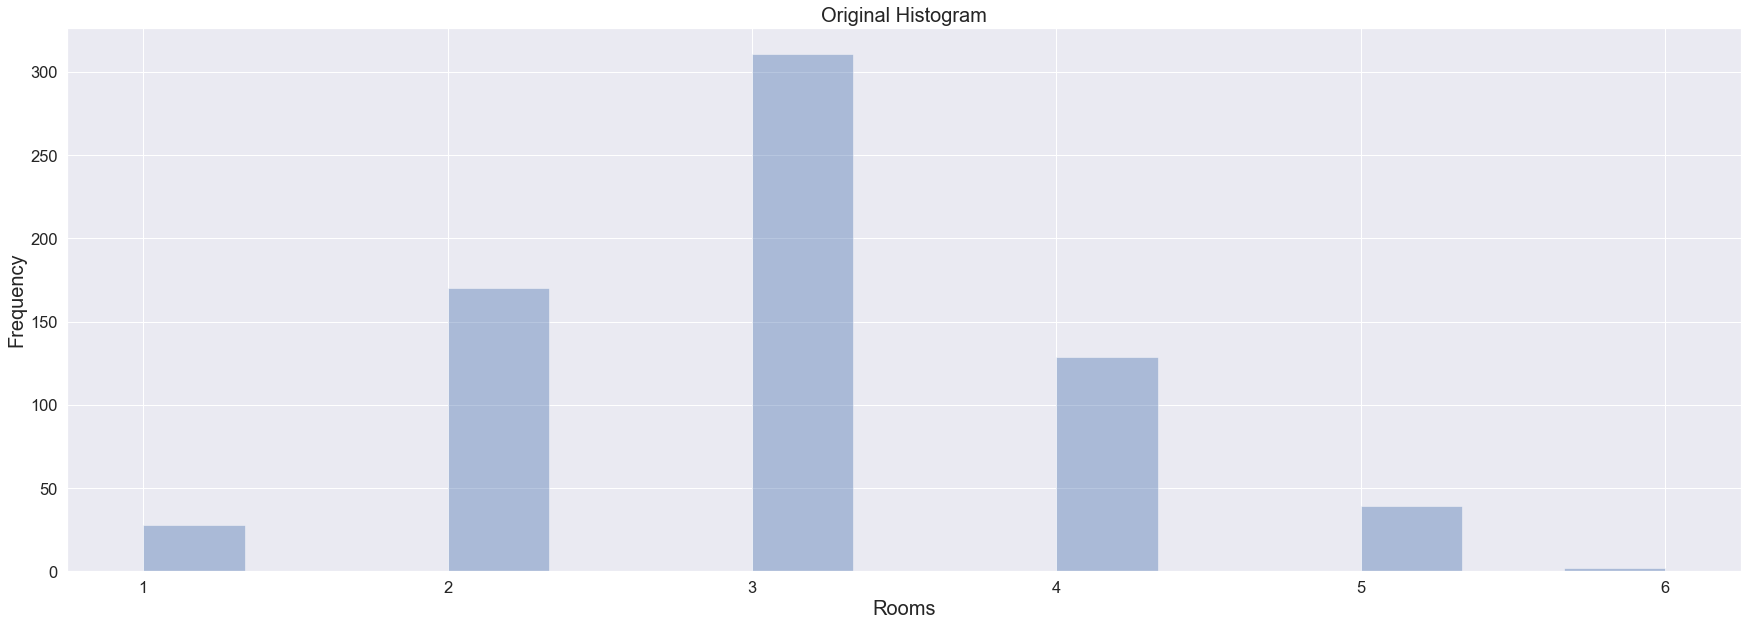

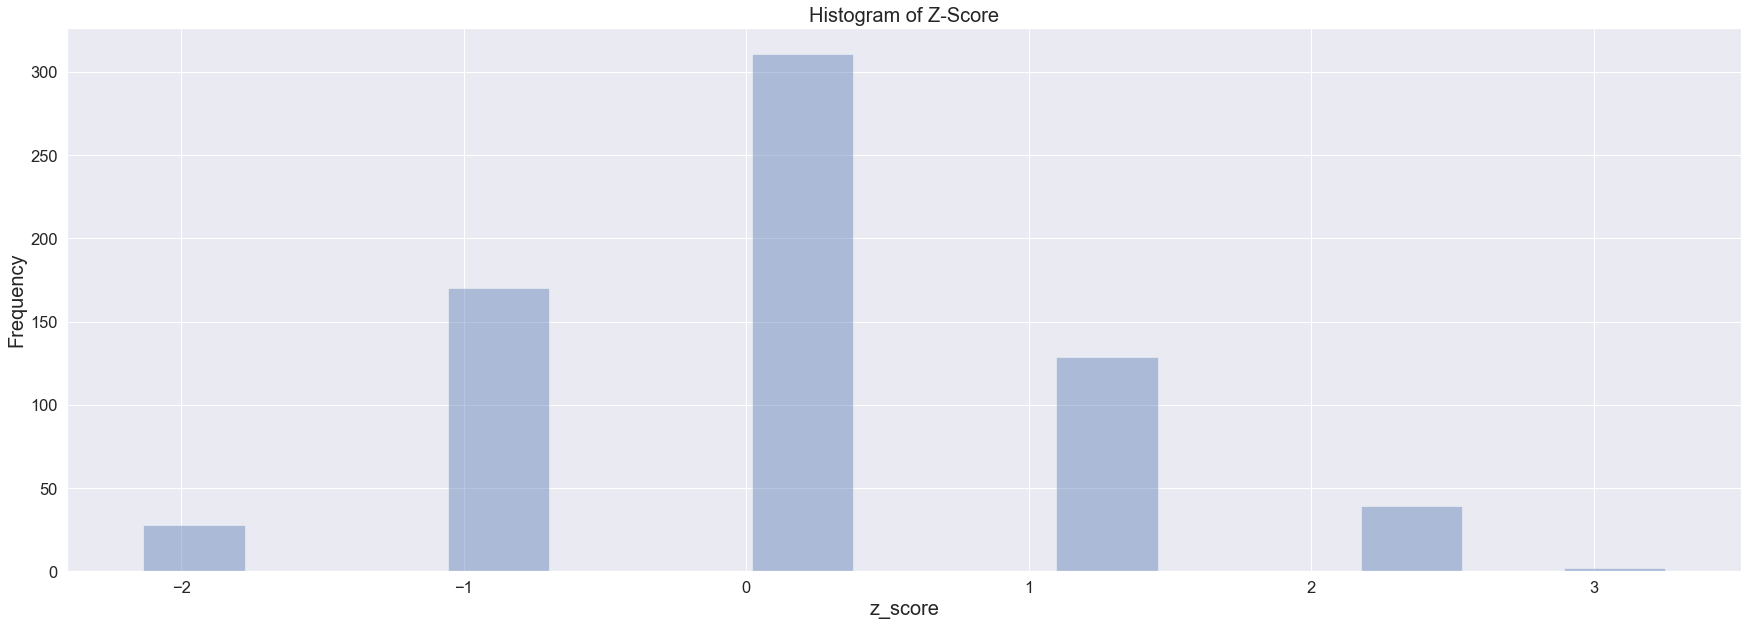

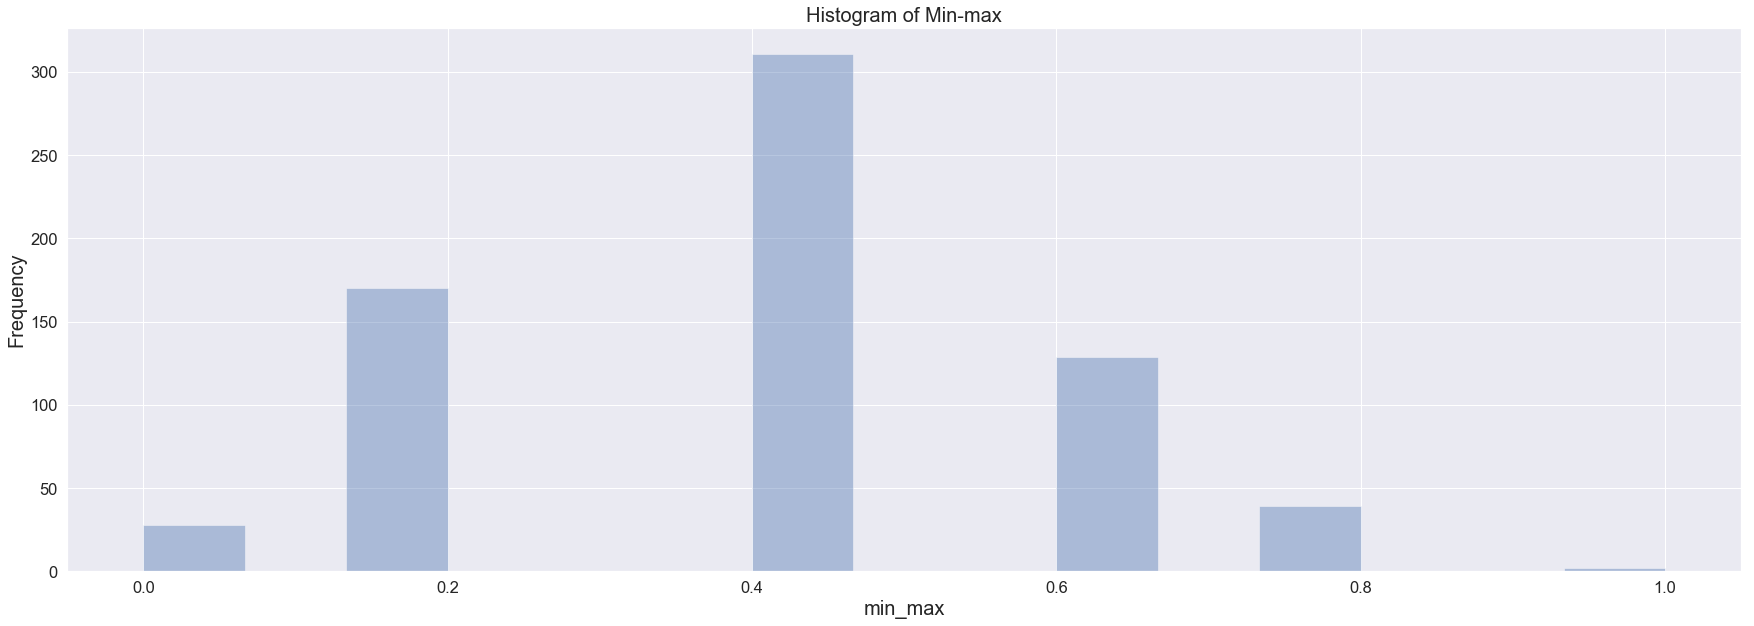

In [40]:
visualise_normalisation('Rooms')


#### crime_C_average normalisation

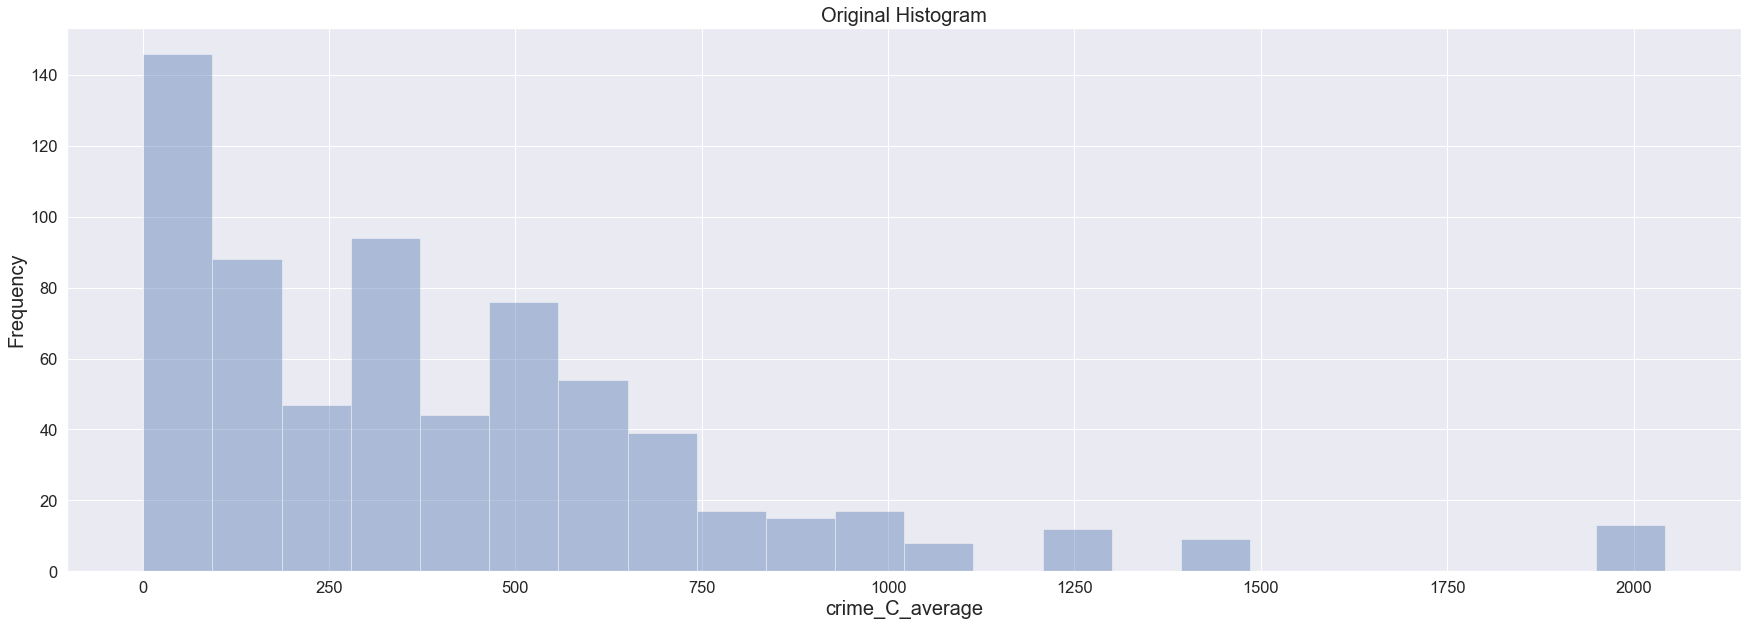

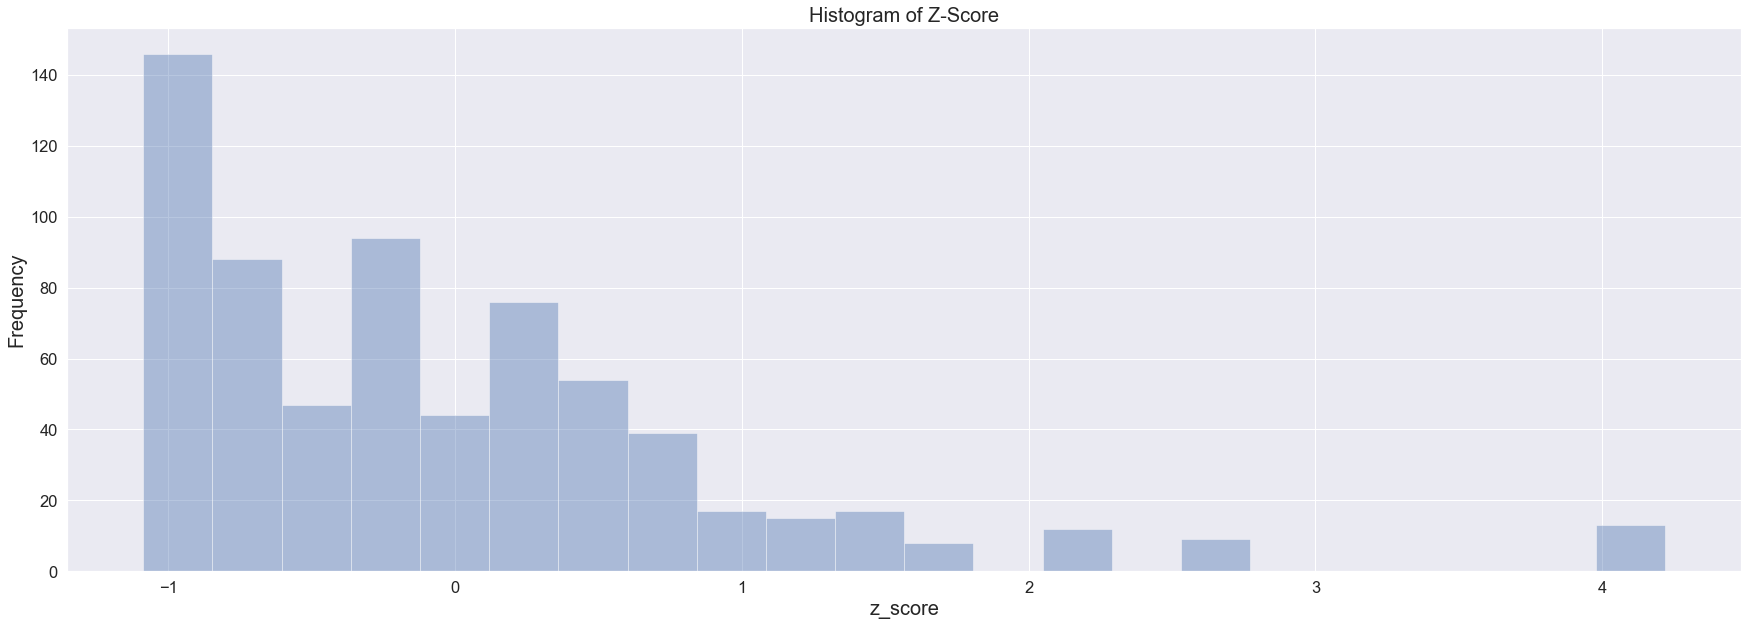

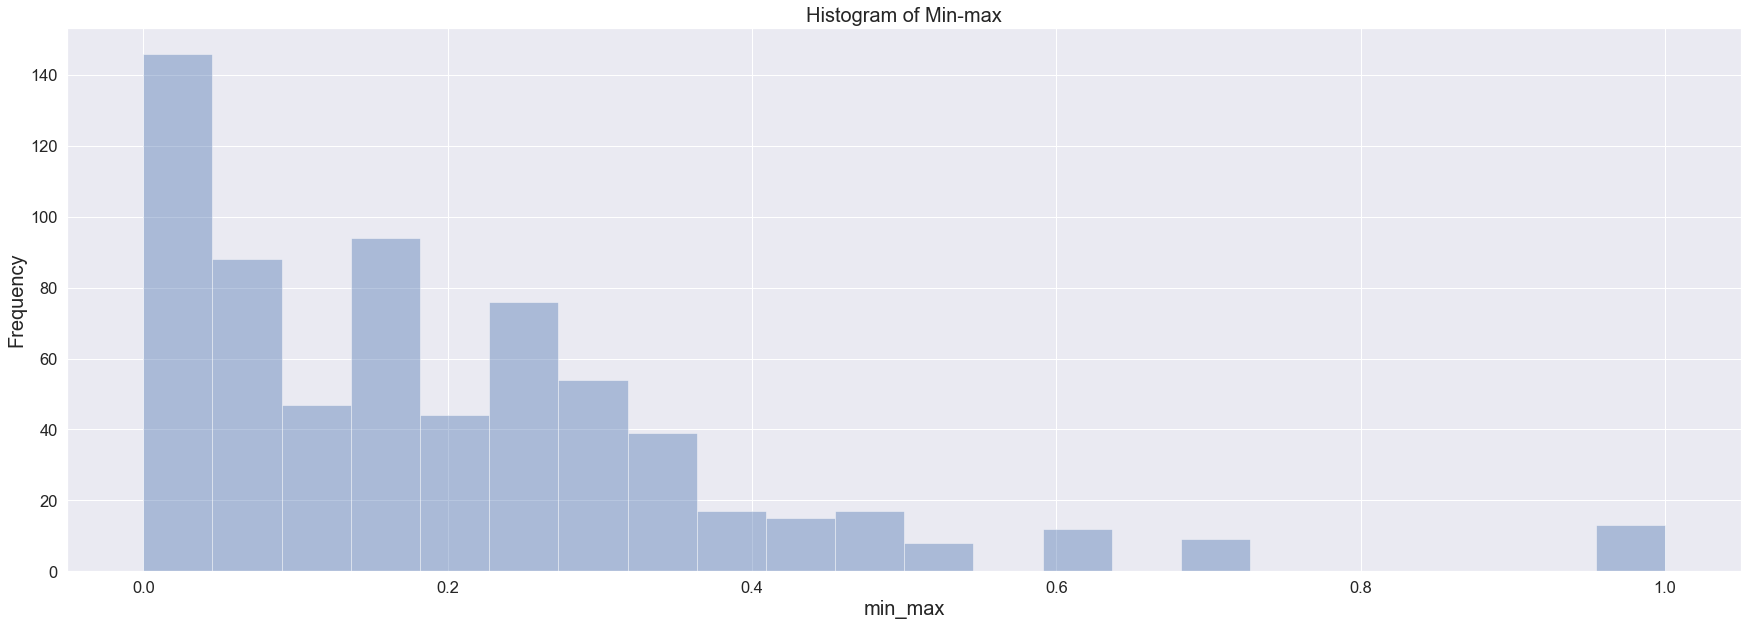

In [41]:
visualise_normalisation('crime_C_average')


#### travel_min_to_CBD normalisation

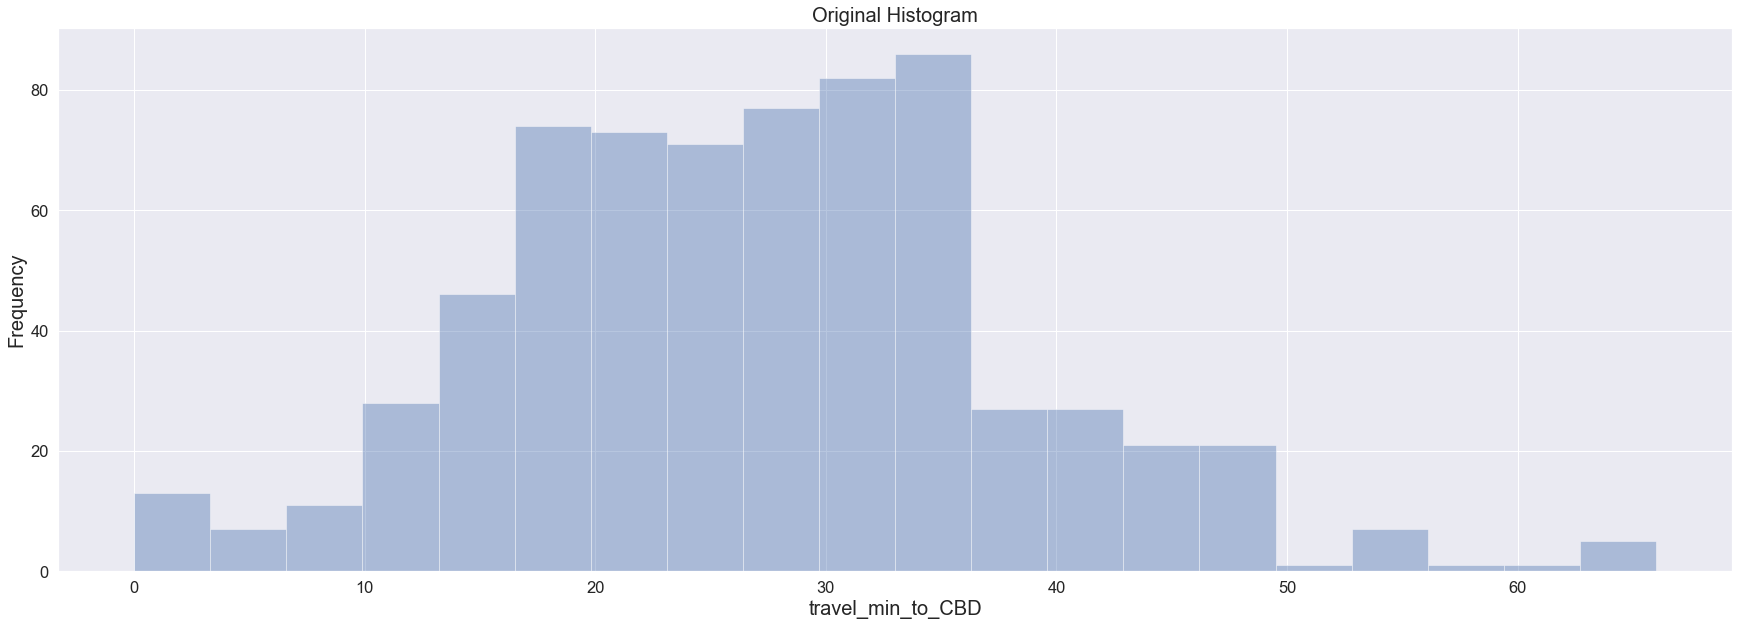

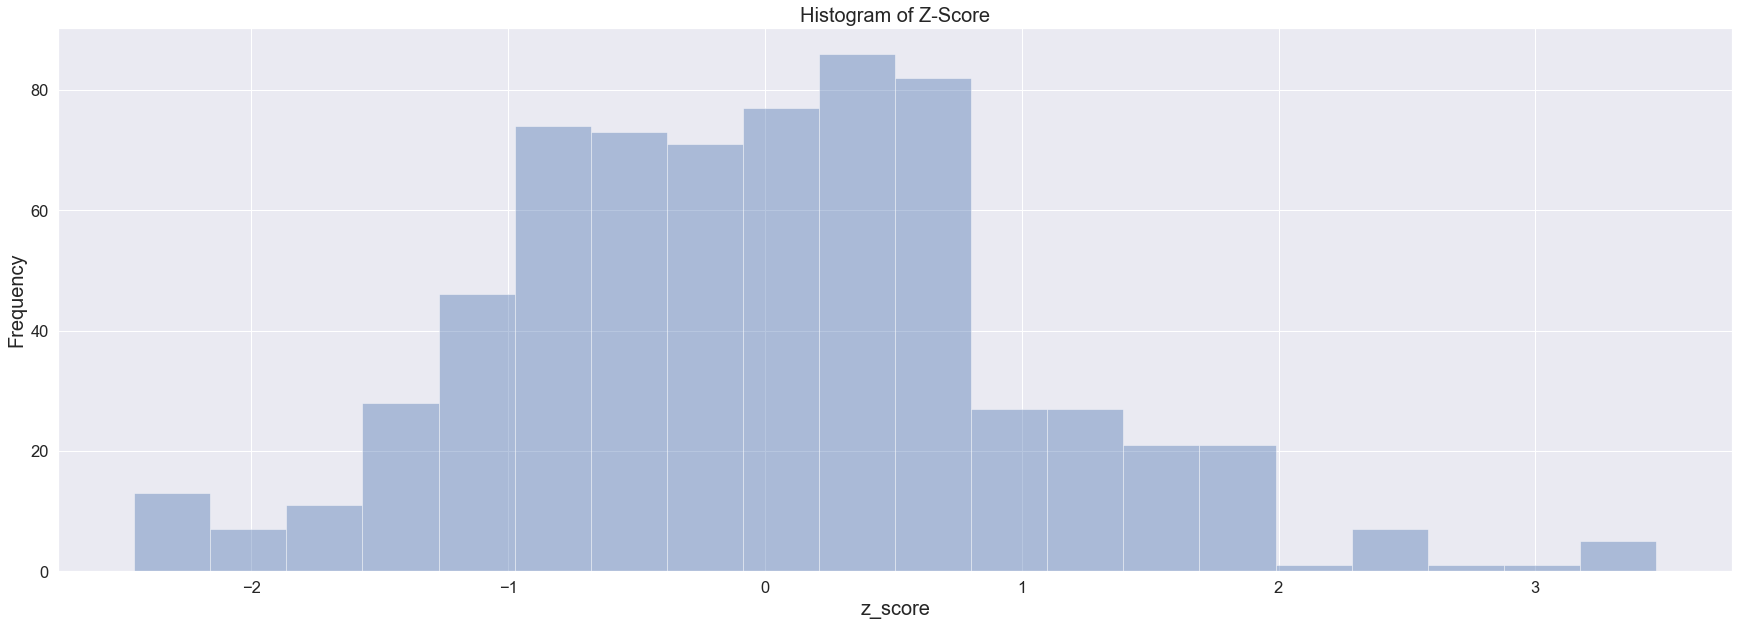

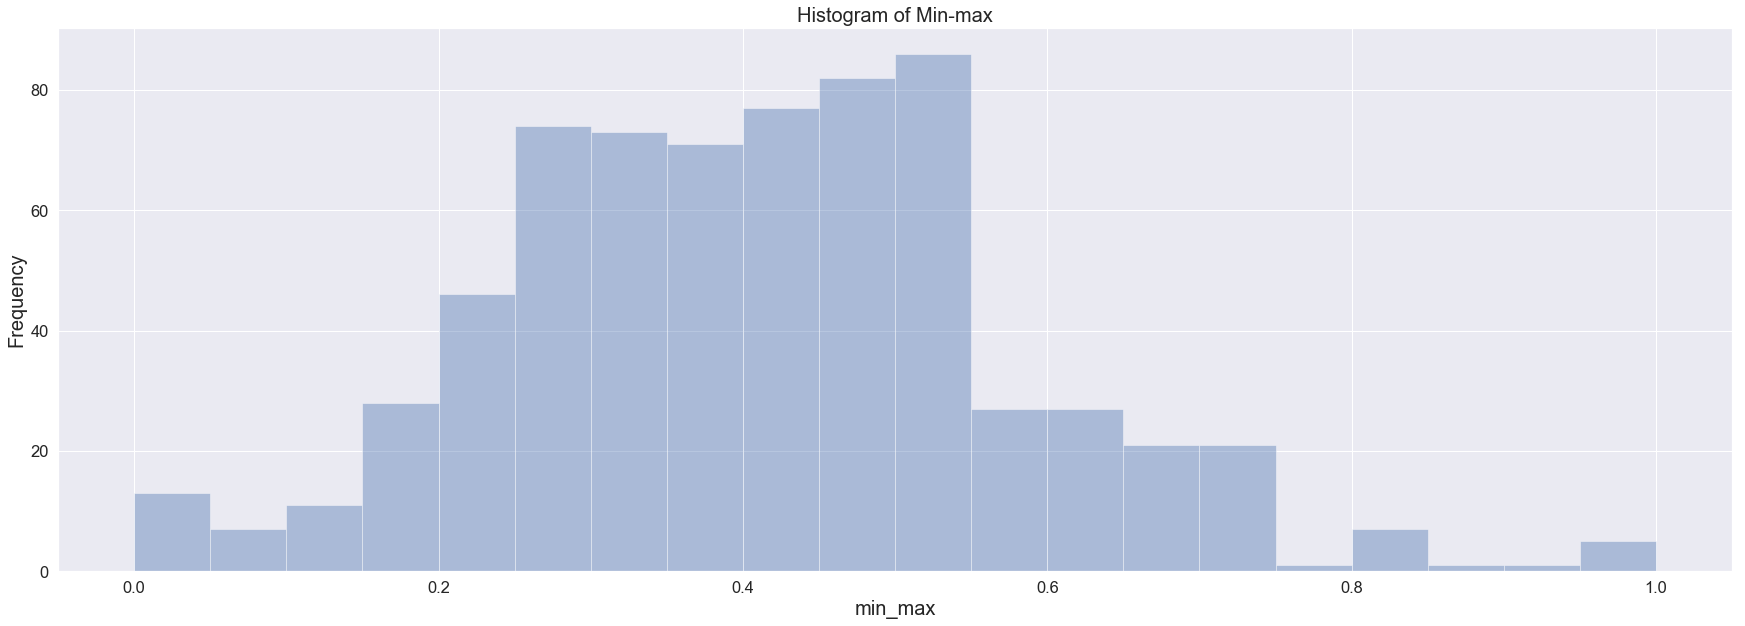

In [42]:
visualise_normalisation('travel_min_to_CBD')


#### property age

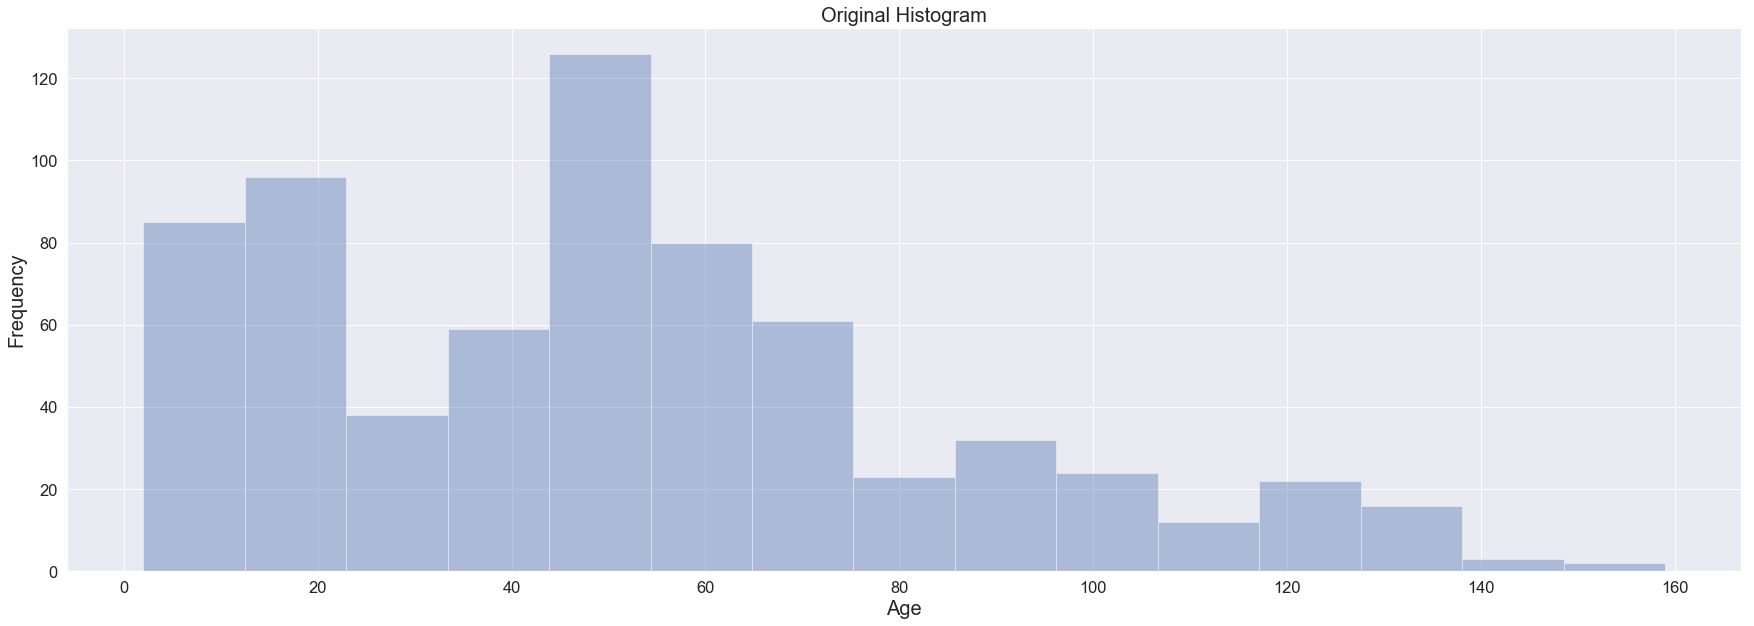

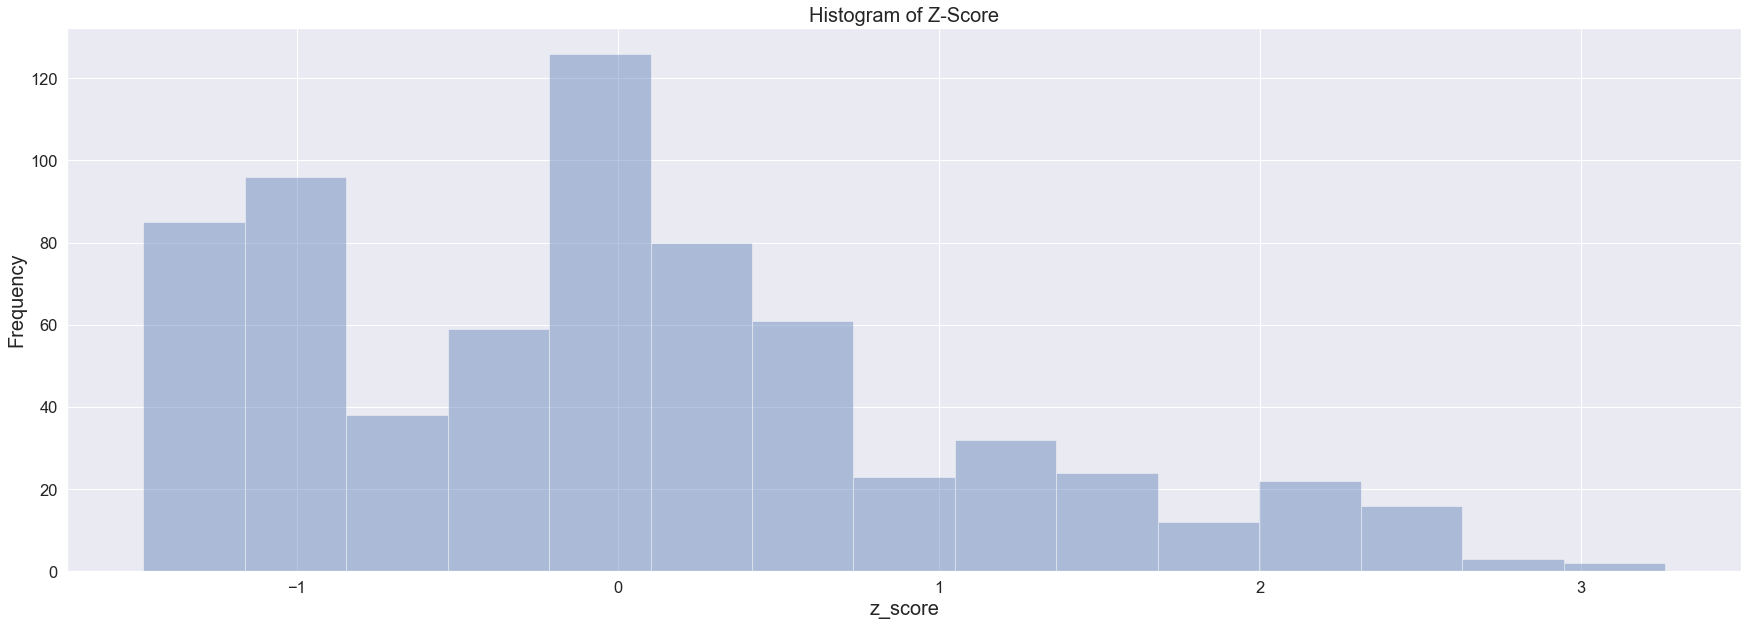

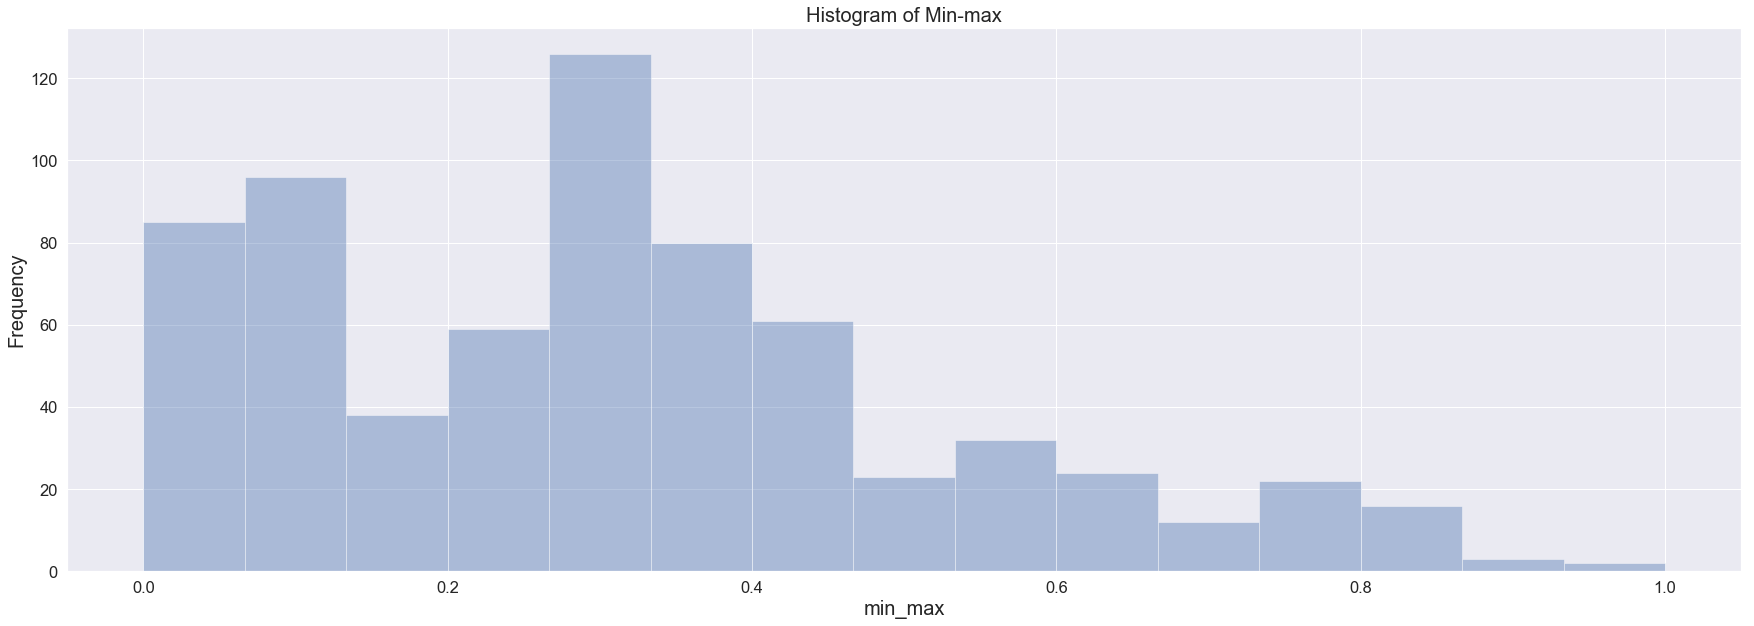

In [43]:
visualise_normalisation('Age')


#### Findings on Normalisation Techniques

From these plots in the previous sections, we can see that apply both z-score and min-max normalisation to the selected attributes doesn't necessarily do all that much. The data retains the same frequency and distribution as before normalisation. However, something that does change for all of these attributes is the x-values - each z-score and min-max changes the range significantly. For instance, the z-score normalised Age sees its standard deviation converted to one and its mean to zero, with a range of -1 to 3. Likewise the min-max normalisation sees its standard deviation converted to 0, its mean to zero, and its range to 0 to 1.

In terms of using these normalised attributes as predictors for a linear model on Price - these techniques would not help, and I would advise that they are mostly useless in the scenario. This is because the correlation between Price and the various attributes stays the same no matter if the atribute is normalised or not. For example, using property age as an example, we perform a correlation test on Price:

In [44]:
print('Correlation of Property Age and Price:')
df.corr()[['Price']].sort_values(by = 'Price', ascending = False)

Correlation of Property Age and Price:


,Price
Price,1.000000
Rooms,0.494720
Bathroom,0.491104
Car,0.242132
Age,0.239815
z_score,0.239815
min_max,0.239815
Longtitude,0.192773
Landsize,0.187003
crime_A_average,0.161445


As we can see above, the correlation between Price and Age, Age normalised with z_score, and Age normalised with min-max:

* Age:	0.239815
* z_score:	0.239815
* min_max:	0.239815

The correlation remains the same! Thus, there is not much reason to use the normalised attributes in the linear model. The basic rule is that when the attributes in question are expressed in the same unit of measure and there are no outliers, there is no need to normalise, which is what is happening here. However, I don't necessarily think there is any harm in doing these normalisations. 


### 4.2 Transformation

Next, we can do the data transformation, which is the replacement of a variable by a function of that variable, and in this case:

- Log transformation: is commonly used for reducing right skewness and is often appropriate for measured variables.
- Power transformation: creates a monotonic (varying in such a way that it either never decreases or never increases) transformation of data.

- Sqrt (Root) transformation: is a transformation with a moderate effect on distribution shape: it is weaker than the logm but is also used for reducing right skewness


Again, I define some resusable functions to perform these techniques.

In [45]:
def perform_transformation(attribute):

    # Log
    df['log']=np.log(pd.to_numeric(df[attribute]))

    # Power
    df['power']=np.power(pd.to_numeric(df[attribute]), 2)
    
    # Root
    df['root']=np.sqrt((df[attribute]))
    

In [46]:
def visualise_tranformation(attribute):
    
    # Call on the normalisation function
    perform_transformation(attribute)
    
    #histogram of price_ZScore
    plt.figure(figsize = (30, 10))
    plt.xlabel('price_log',size=20)
    plt.ylabel('Frequency',size=20)
    plt.title('Original Histogram',size=20)
    sns.distplot(df[attribute], kde=False)
    plt.show()
    
    #histogram of price_ZScore
    plt.figure(figsize = (30, 10))
    plt.xlabel('Log',size=20)
    plt.ylabel('Frequency',size=20)
    plt.title('Histogram of Log',size=20)
    sns.distplot(df['log'], kde=False)
    plt.show()
    
    #histogram of price_ZScore
    plt.figure(figsize = (30, 10))
    plt.xlabel('Power',size=20)
    plt.ylabel('Frequency',size=20)
    plt.title('Histogram of Power',size=20)
    sns.distplot(df['power'], kde=False)
    plt.show()
    
    #histogram of price_ZScore
    plt.figure(figsize = (30, 10))
    plt.xlabel('Root',size=20)
    plt.ylabel('Frequency',size=20)
    plt.title('Histogram of Root',size=20)
    sns.distplot(df['root'], kde=False)
    plt.show()

Next, I call on these function using the attributes in question.

#### Rooms transformation

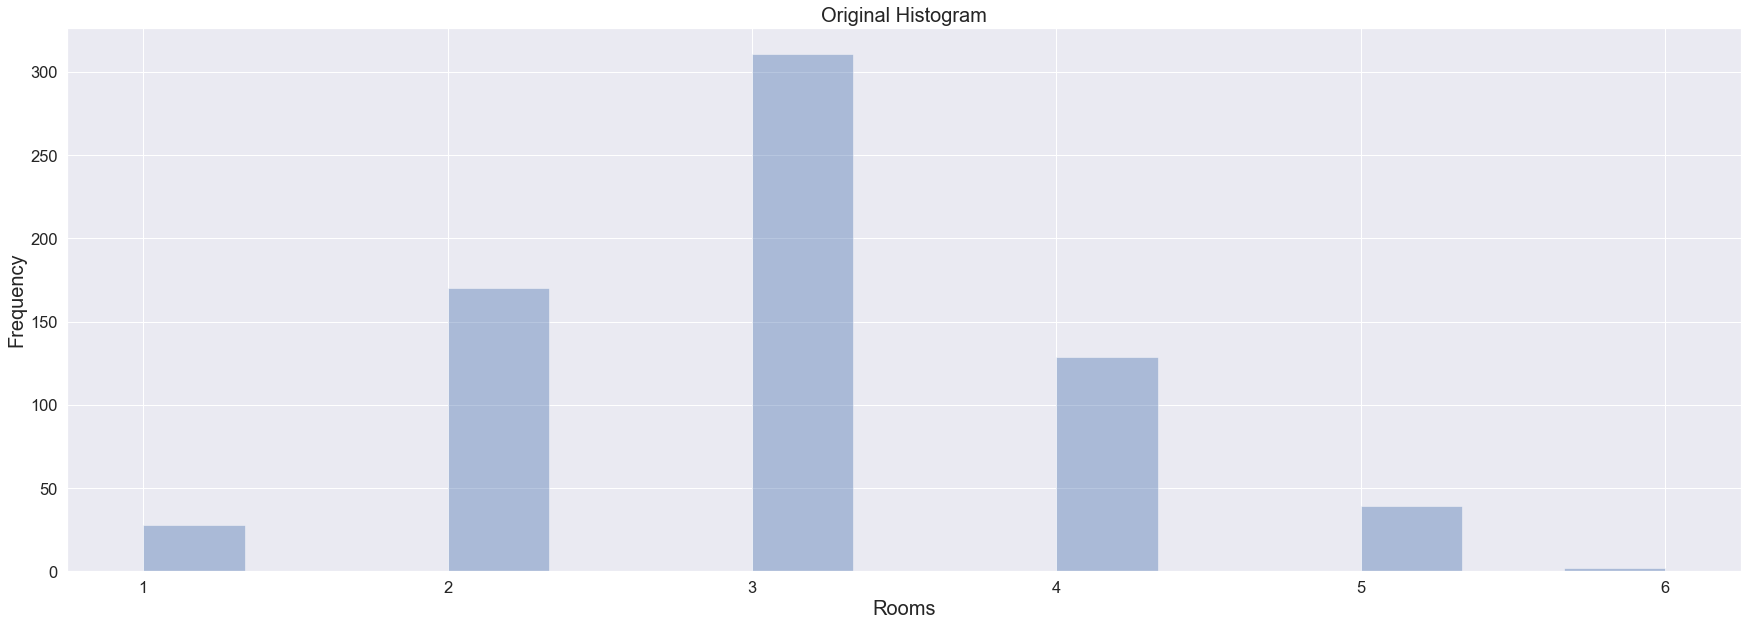

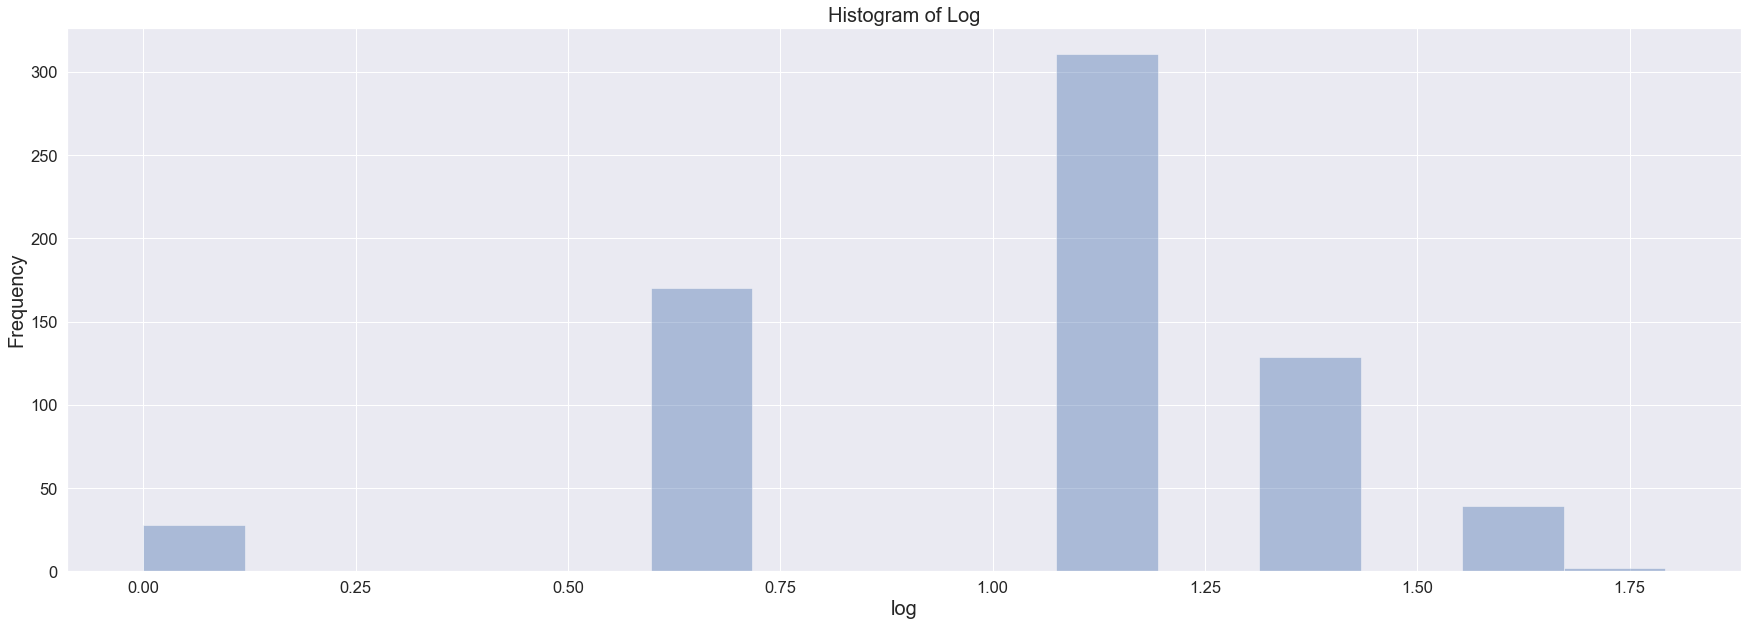

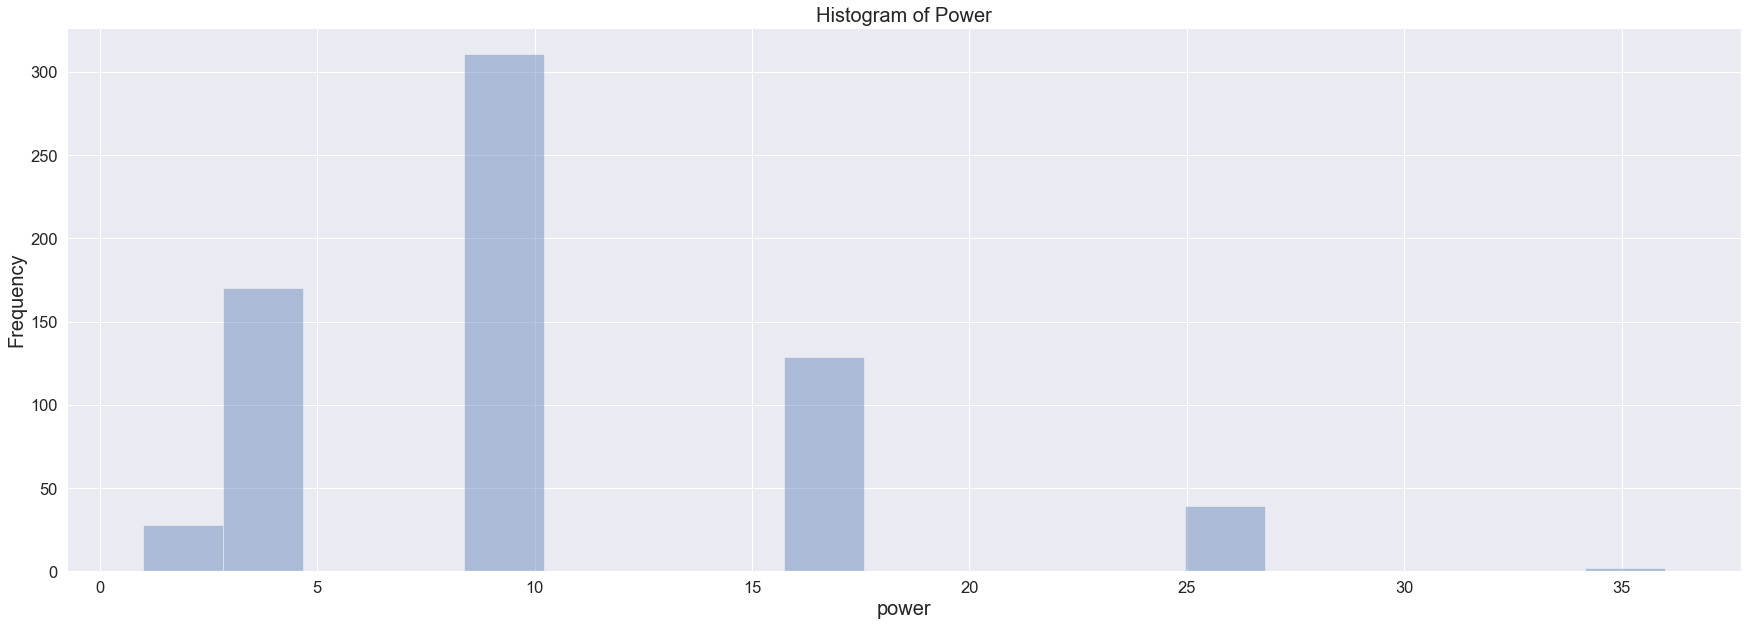

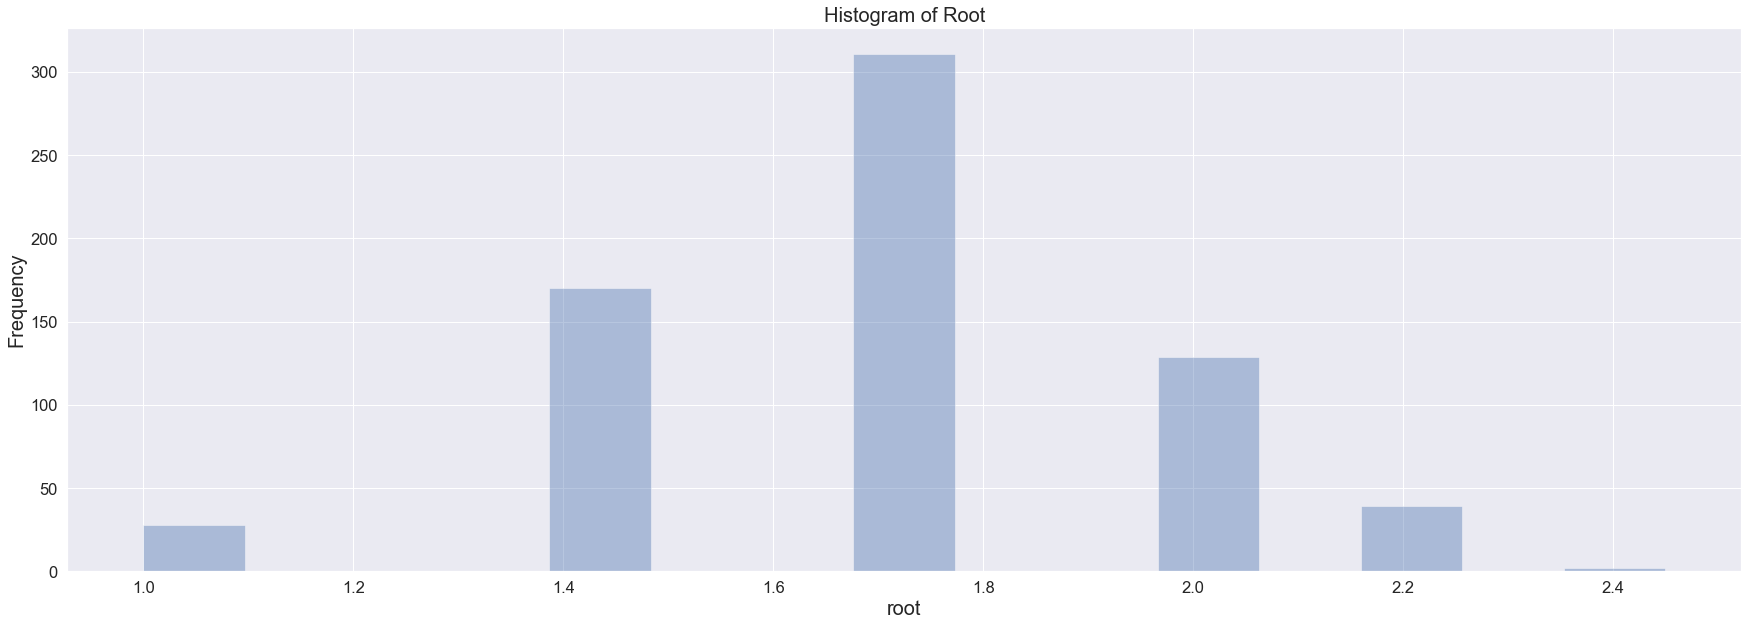

In [47]:
visualise_tranformation('Rooms')


#### crime_C_average transformation

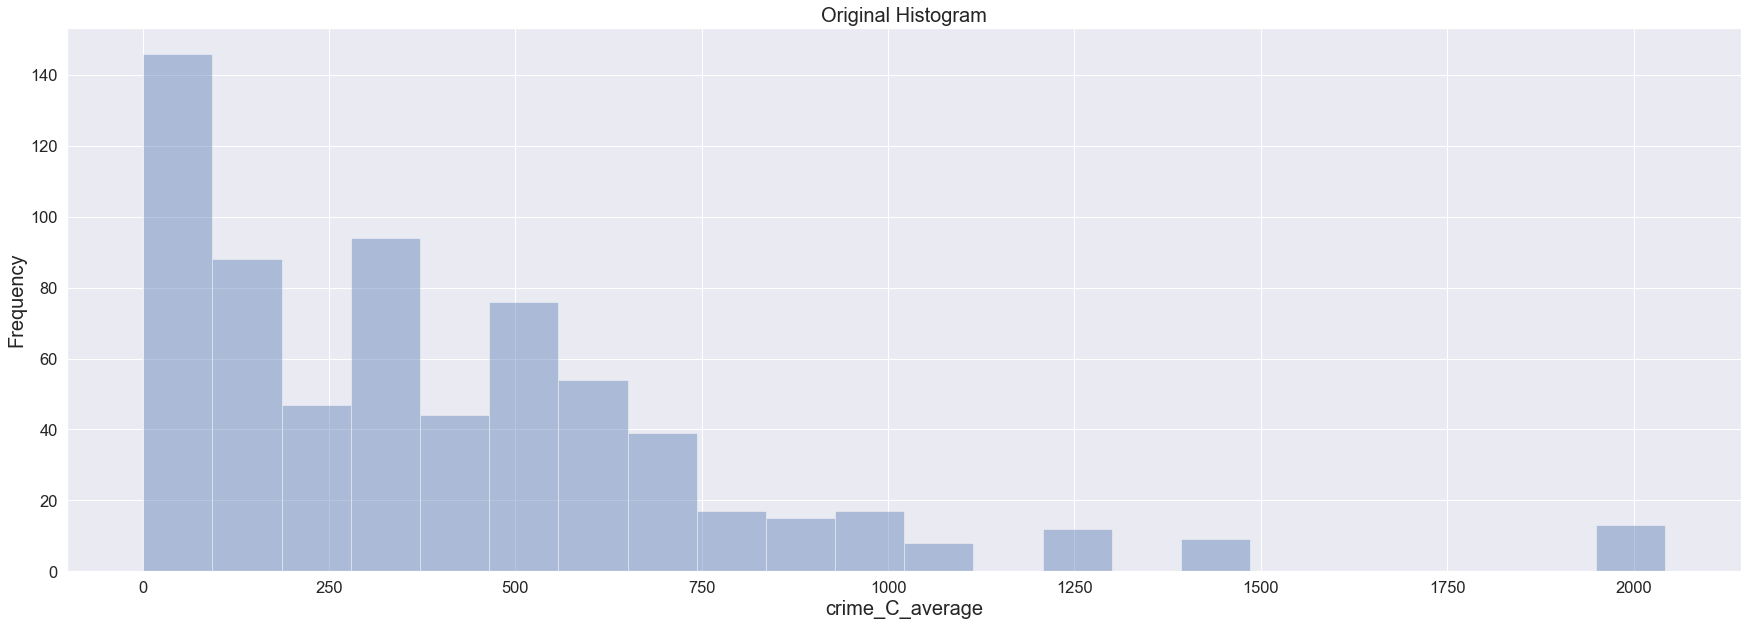

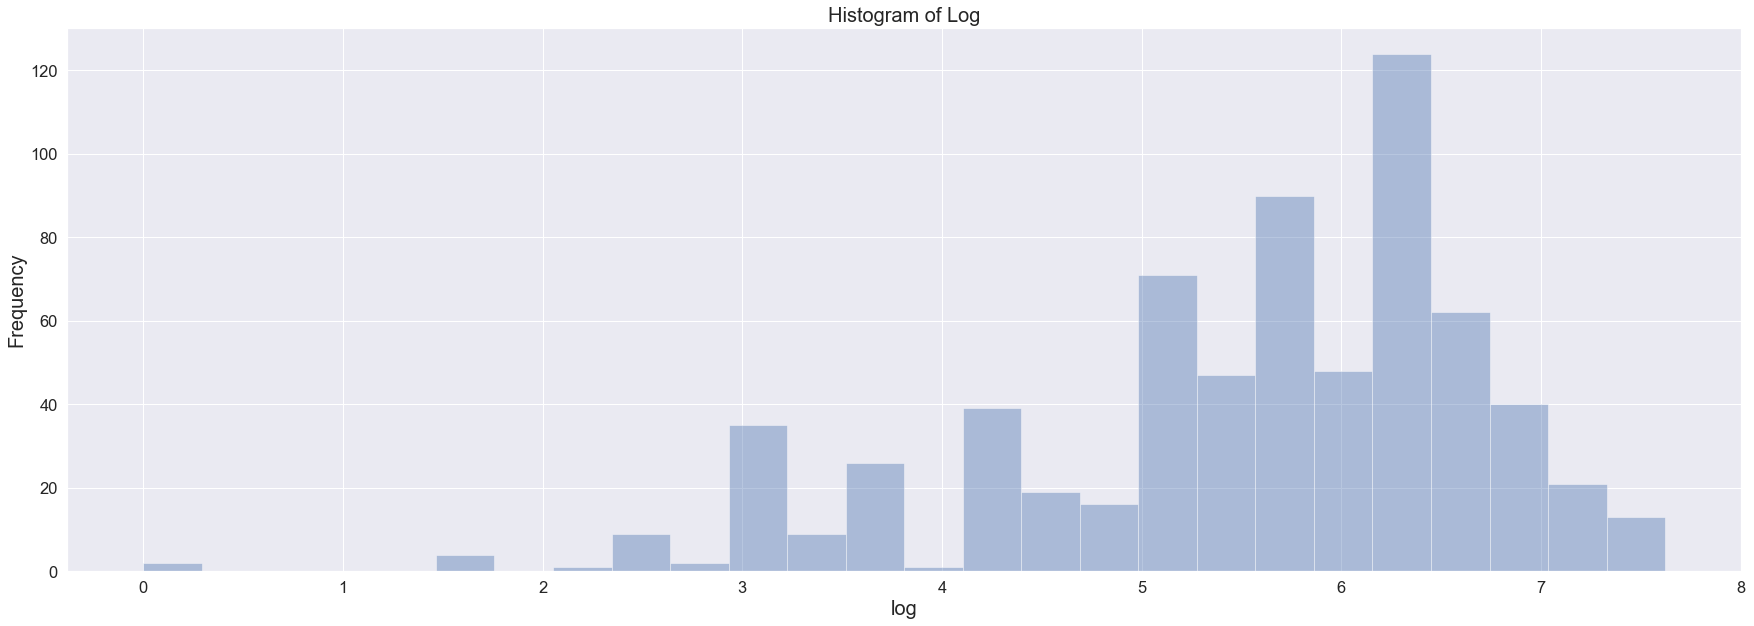

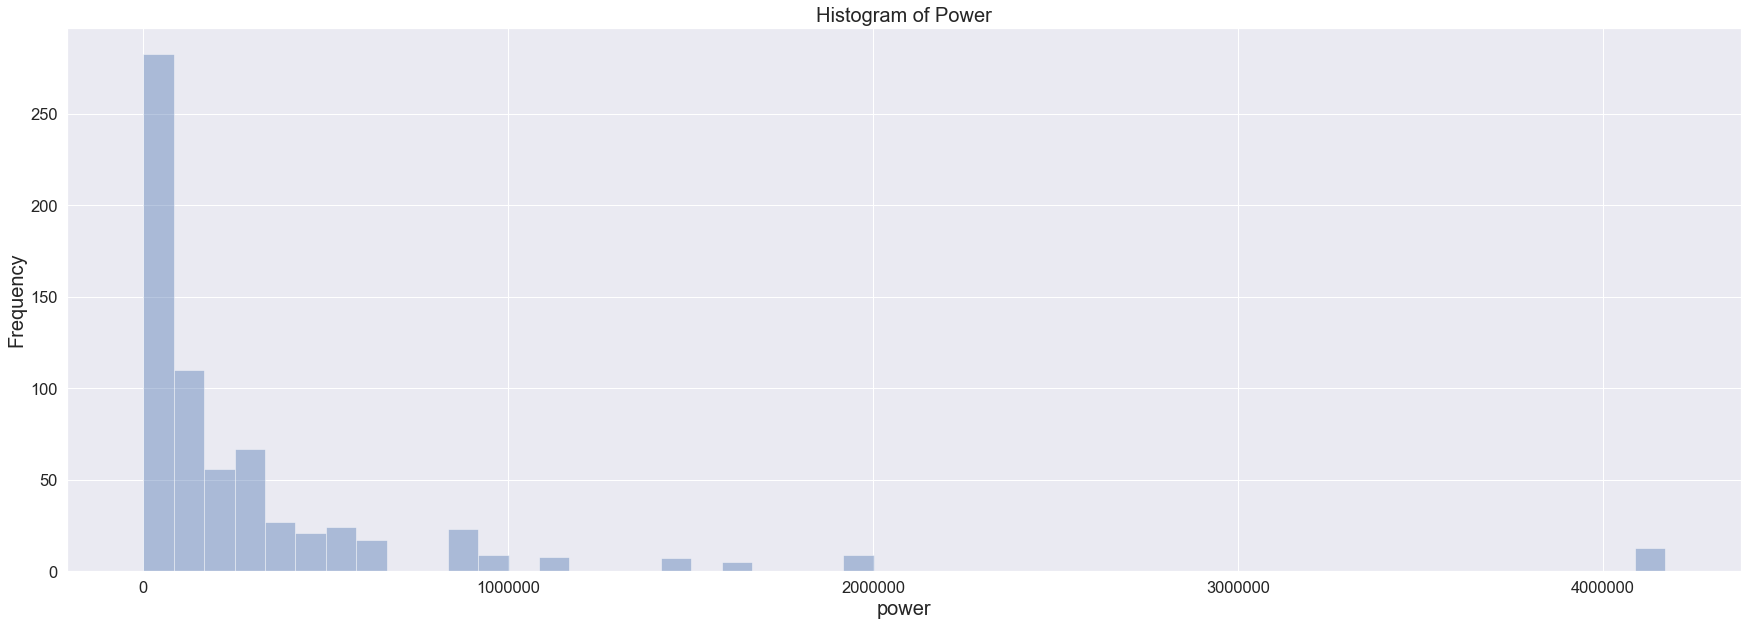

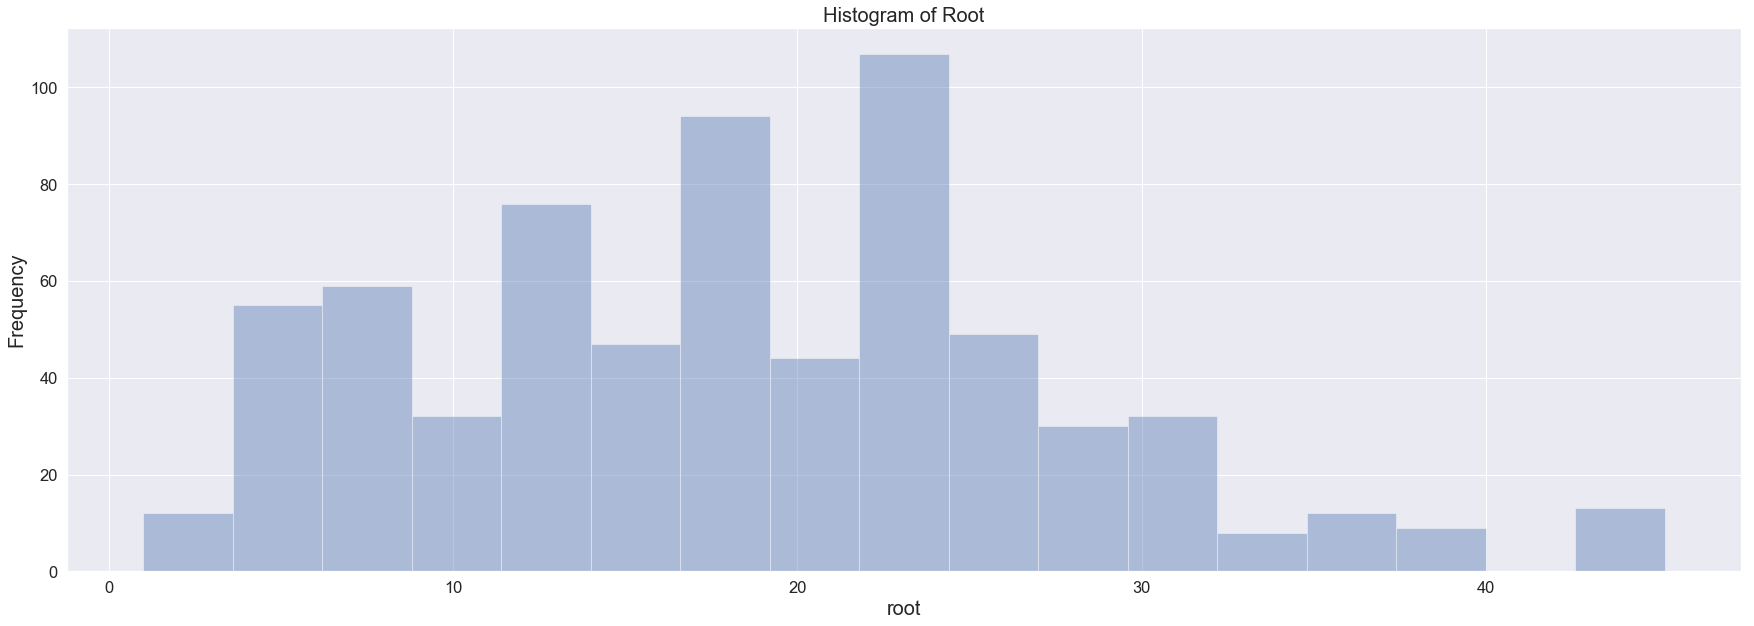

In [48]:
visualise_tranformation('crime_C_average')


#### Age transformation

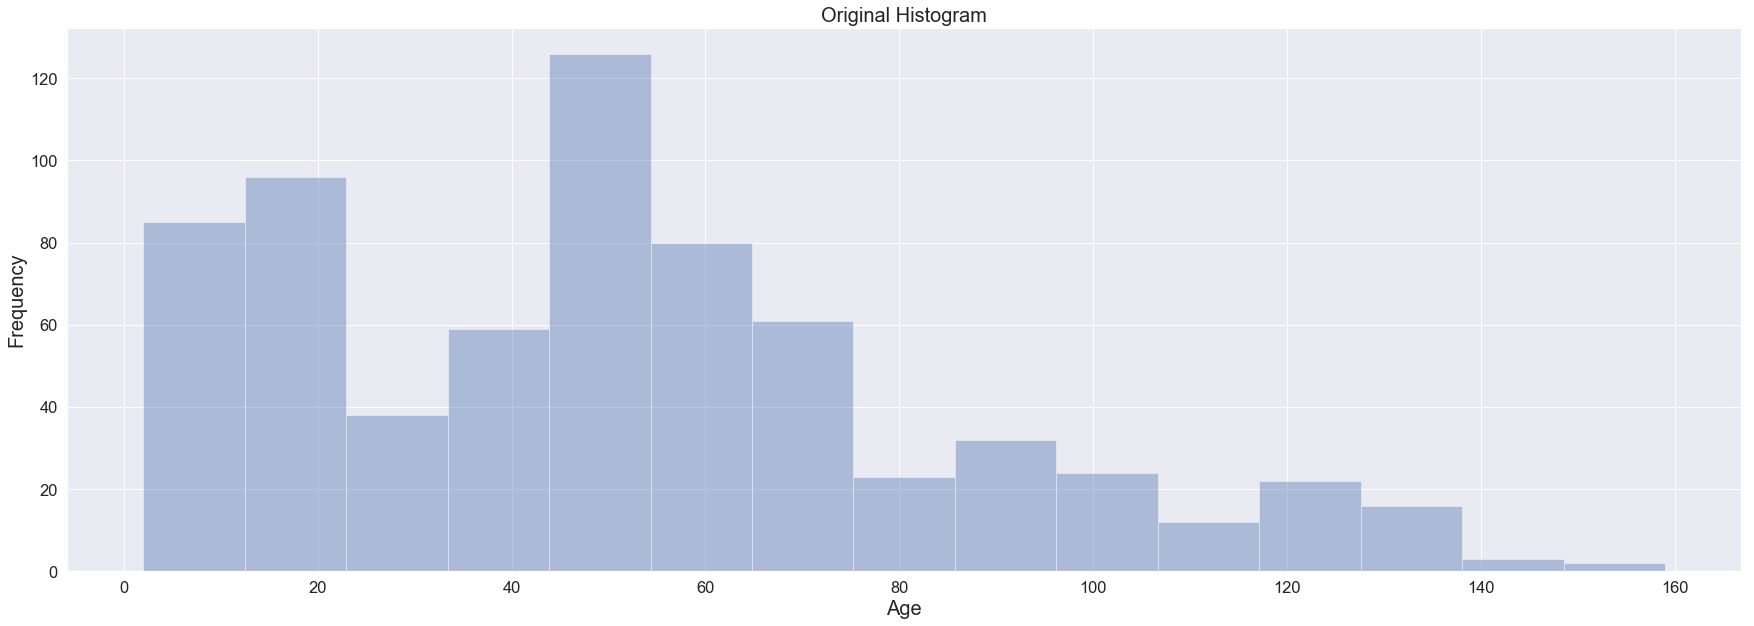

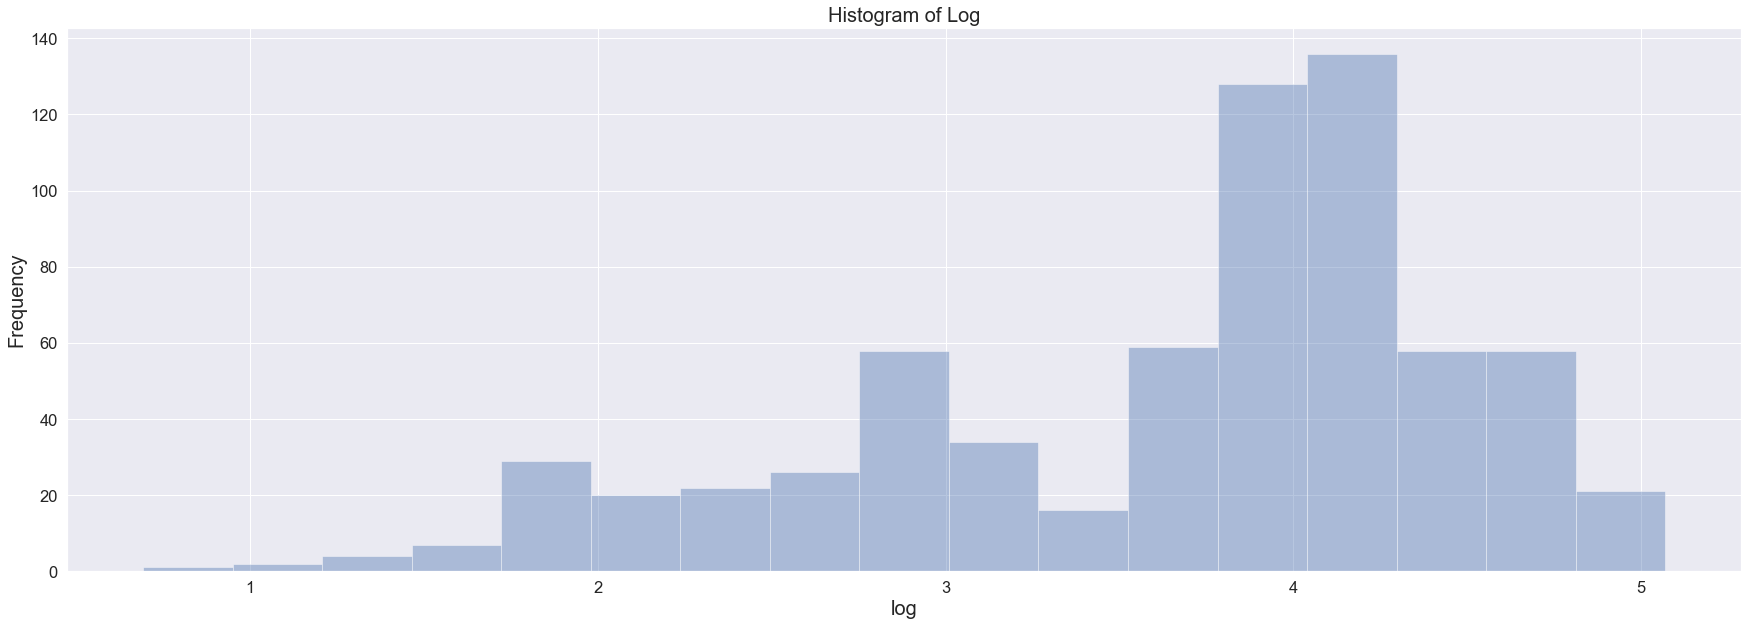

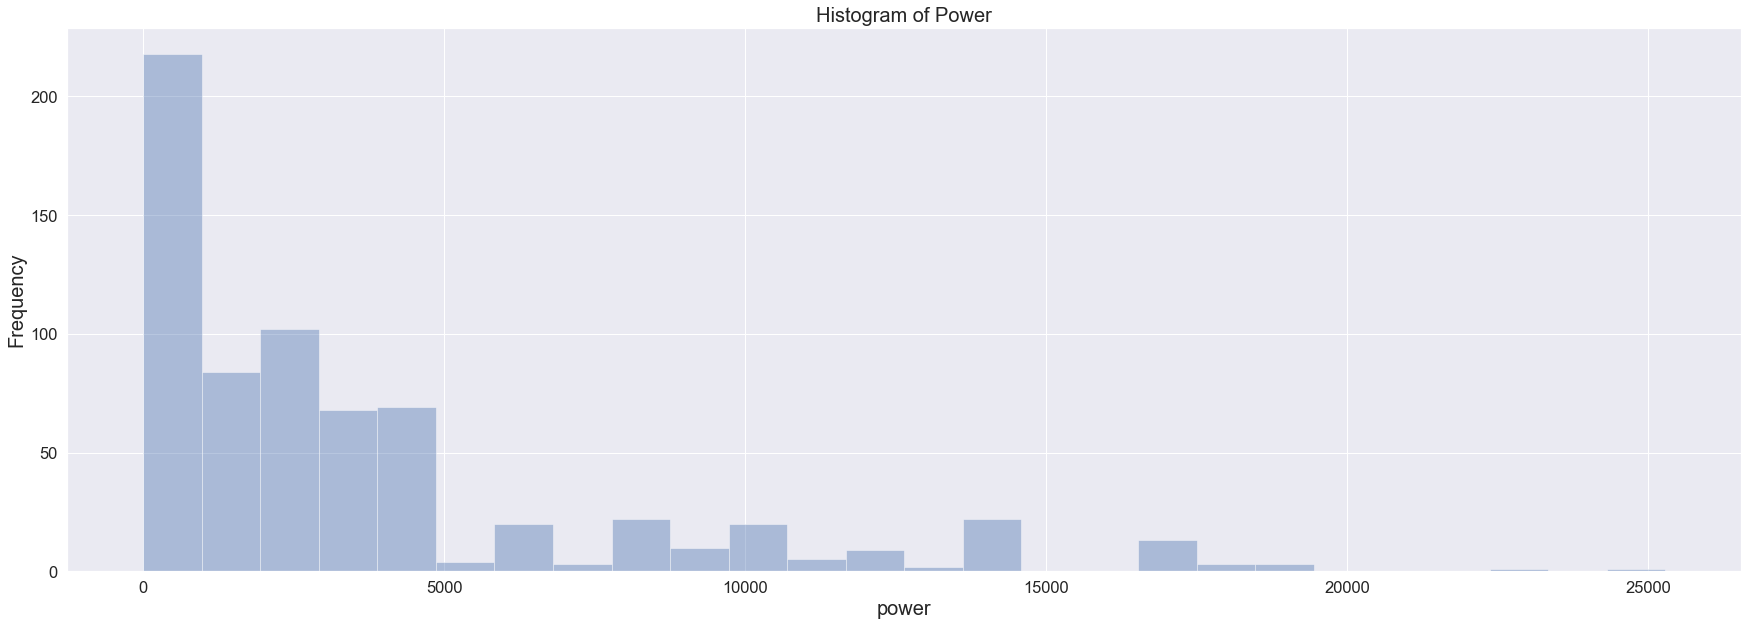

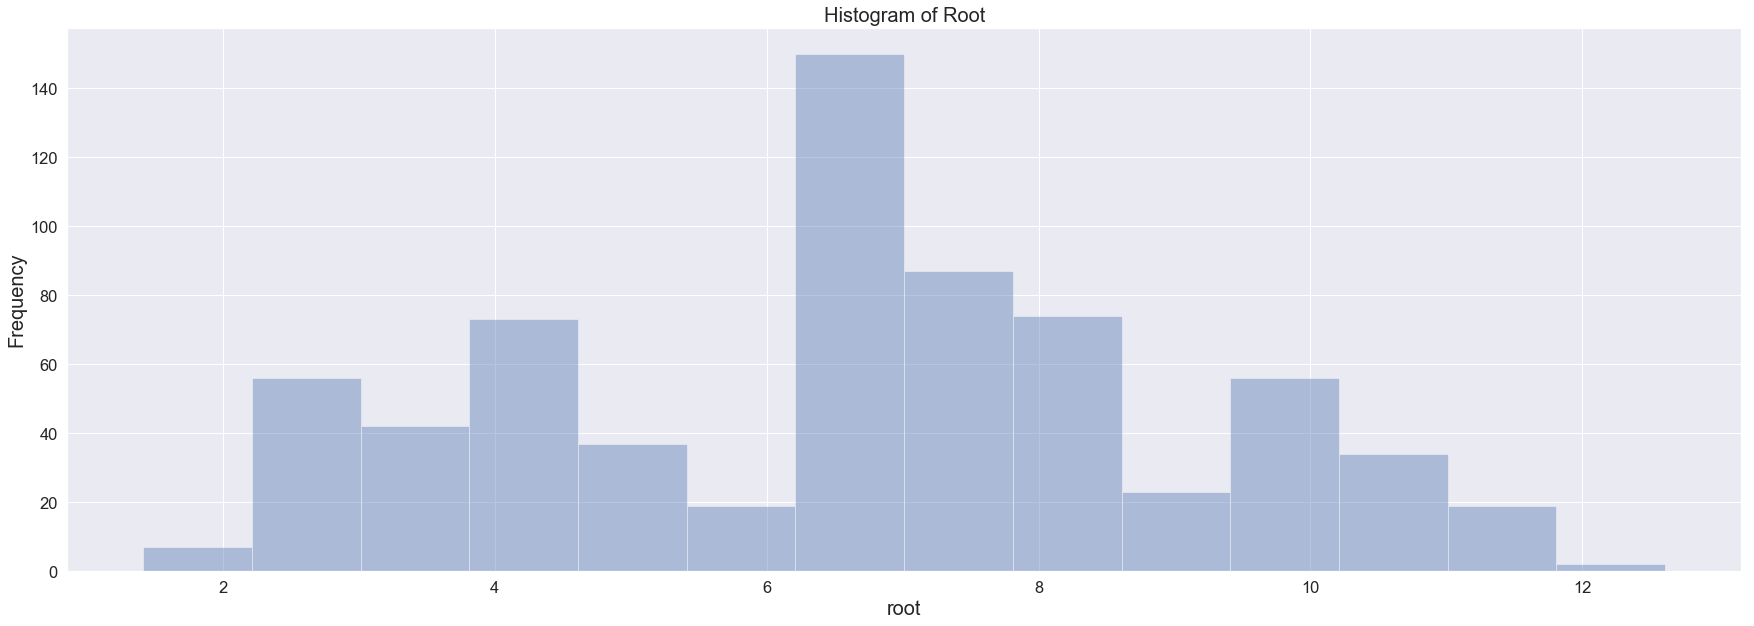

In [49]:
visualise_tranformation('Age')


#### travel_min_to_CBD transformation

Because there are travel times in the integrated dataframe that have the value 0, I have dropped thse rows as these tranformation methods broke without doing that.

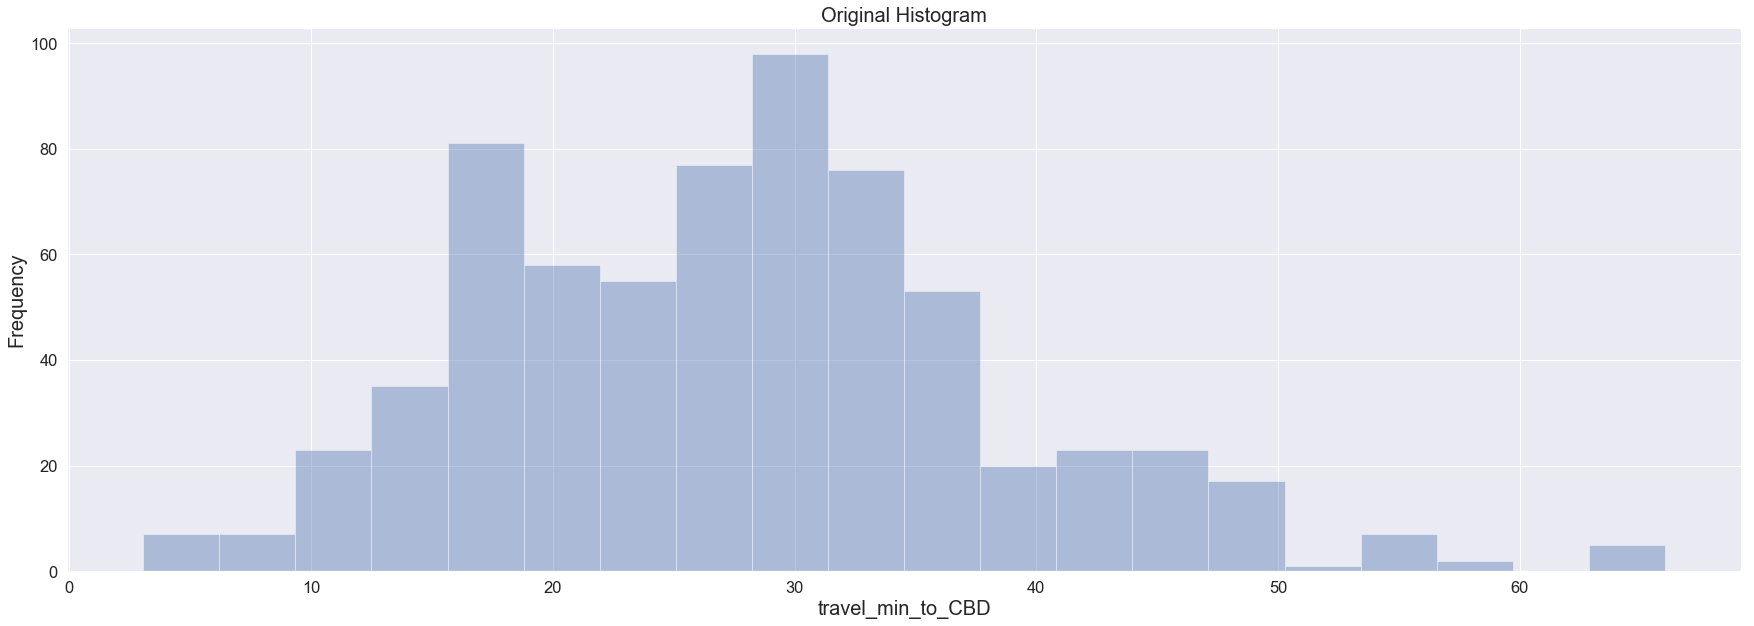

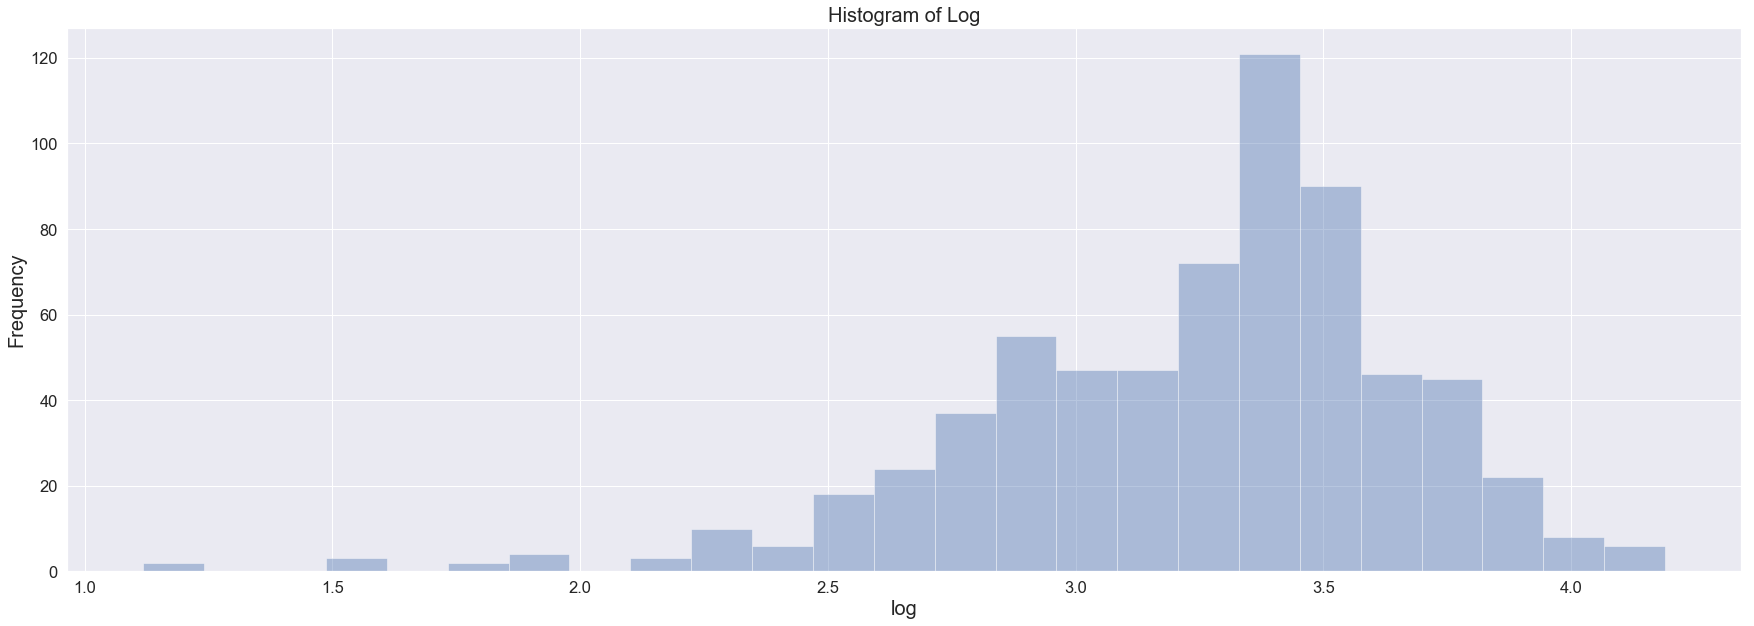

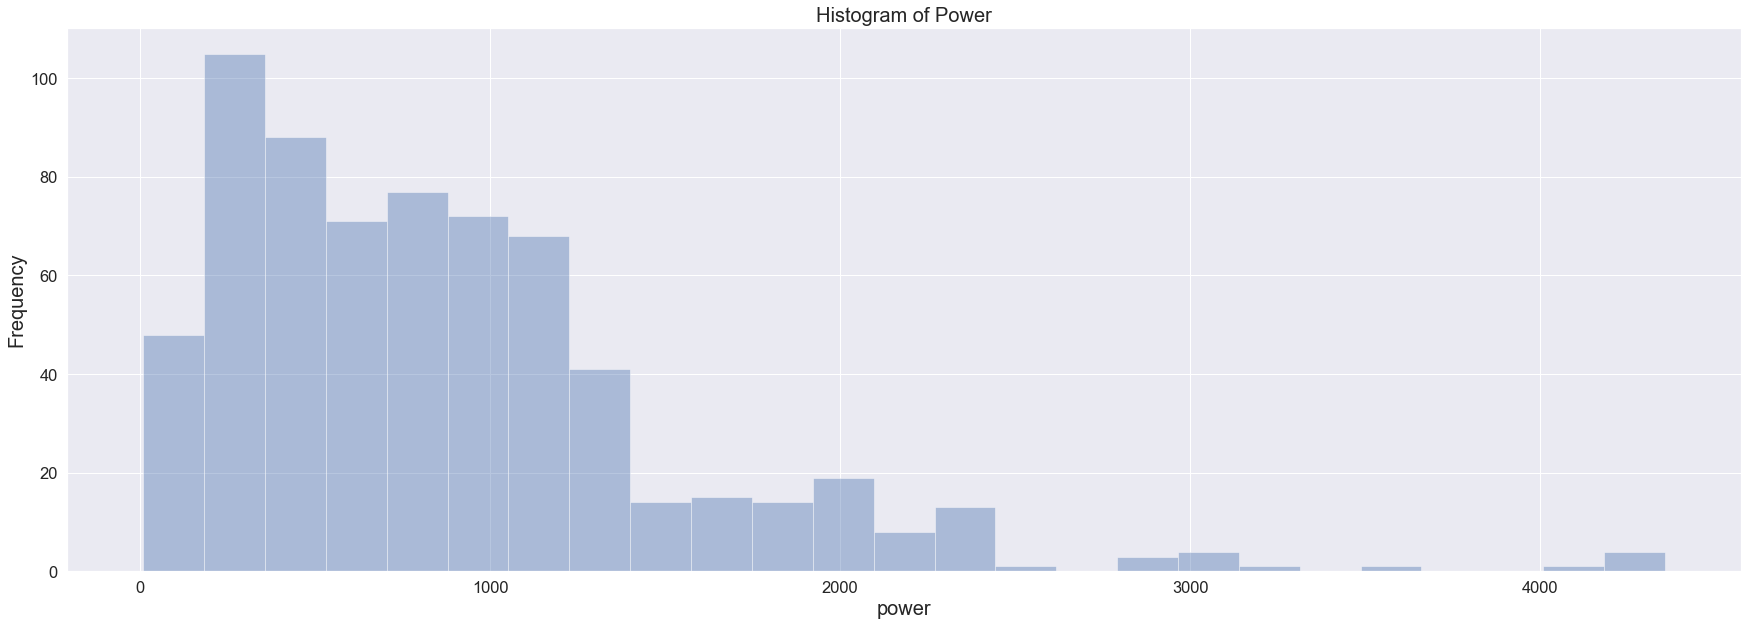

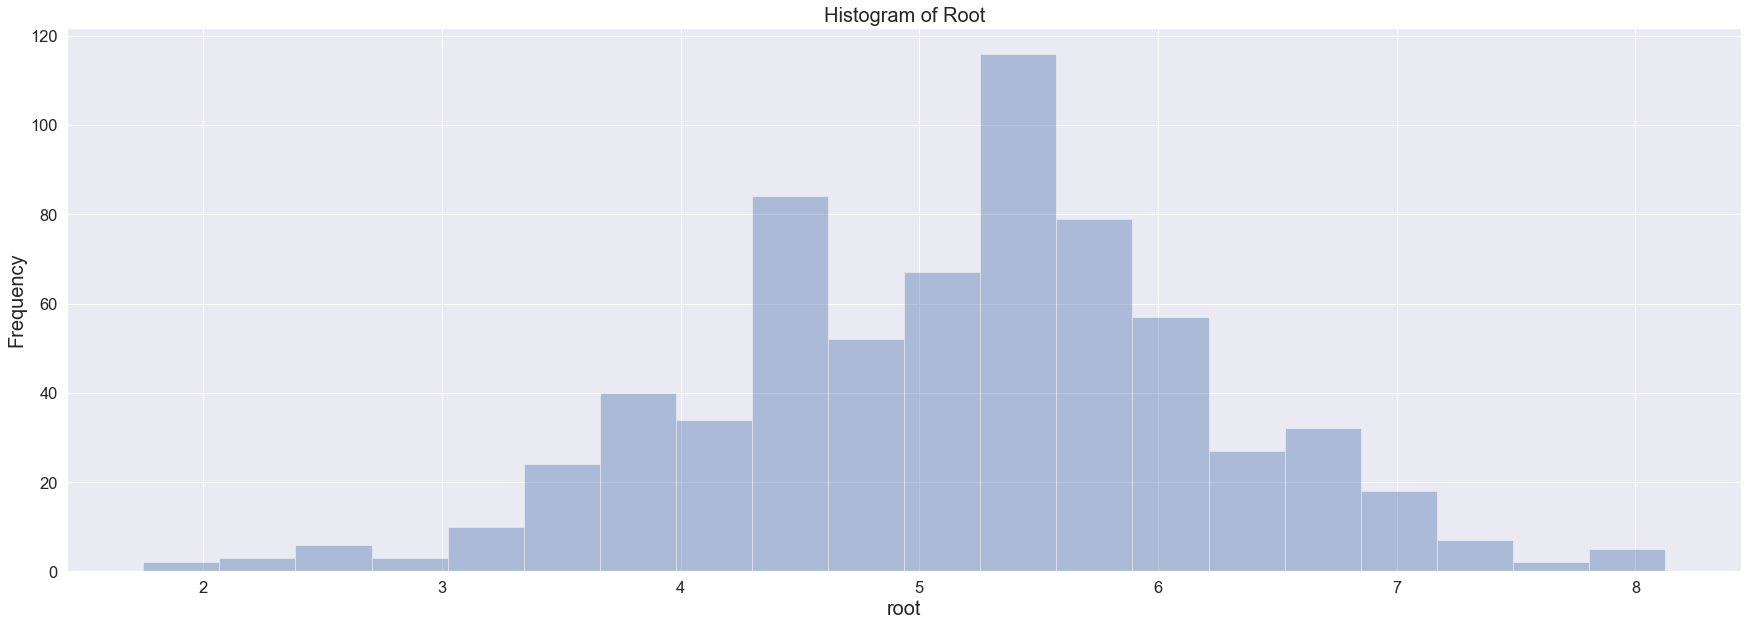

In [50]:
# Drop values of 0
df = df.drop(df[df['travel_min_to_CBD'] == 0].index)

visualise_tranformation('travel_min_to_CBD')


#### Findings on Transformation Techniques

The main criterion in choosing a transformation is: what works with the data? By analysing these plots above, we can see that with log transformation, the skewness of the data distribution is adjusted and becomes more balanced/symetrical for the attributes: crime_C_average, travel_min_to_CBD, and property_age. This is because these attributes are right (or positively) skewed, meaning that we need to reduce the number of large records, so that the data is more distributed or spread out around the lower values - or the outliers are reduced.

Moving onto Rooms - as there is only six possible values in rooms, and there is already a symmetric or even distribution of values (the mean value is 2.98), I am inclined to say that none of the transformation methods have a positive effect on this attribute.

Therefore, I would recommend log transformation for the attributes: crime_C_average, travel_min_to_CBD, and property_age; and, no transformation for the attribute Rooms.


## 5. Summary
 
This assignment involved the data integration of various datafiles, and the transformation of various attributes from this file in order recommend future linear regression.

The main tasks are summarised as follows:


- **Task 1: Data integration**. This was a long process with a lot of trial and error involved. I used a lot of the functionality that Pandas offers, which is a really powerful way of working with large/multiple/complicated datasets.


- **Task 2: Data Integration**. This was a relatively straightforward task. By using the normalisation and transformation techniques, I was able to recommend which would be suitable for future linear regression works.




## 6. References

Sarda, S. (2018, December 9). Pandas: Splitting (Exploding) a column into multiple rows. Retrieved from:
https://medium.com/@sureshssarda/pandas-splitting-exploding-a-column-into-multiple-rows-b1b1d59ea12e



Vadali, S. (2017, December 30). Day 8: Data transformation — Skewness, normalization and much more. Retrieved from:
https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55



unutbu.  (2013, June 12). Re: Select rows from a DataFrame based on values in a column in pandas [Online forum post]. Retrieved from
https://stackoverflow.com/a/17071908